# Analysis of PINNs solutions

<a id="0"></a> <br>
#Table of Contents
1. [The Helmholtz equation](#1)         
1. [The transport equation](#2)       
1. [The wave equation](#4)
1. [Lotka-Voltera equations](#4)    
1. [Eikonal equation](#6)  
1. [Inviscid Burgers' equation](#7)
1. [Viscous Burgers' equation](#7)   
1. [The KDV equation](#7)
1. [Camassa-Holm equation](#8)

In [ ]:
!pip install deepxde &> /dev/null

In [ ]:
import numpy as np
import tensorflow.compat.v1 as tf

import scipy
from scipy.special import airy
from scipy.integrate import solve_ivp, odeint, quad
from scipy.optimize import minimize
import deepxde as dde

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

from tqdm.notebook import tqdm
import itertools

Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


No backend selected.
Finding available backend...
Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


Enable just-in-time compilation with XLA.



Define the constants and the functions that will be used throught the notebook.

In [ ]:
pi = np.pi

## Lotka-Voltera equations

Consider the Lotka-Volterra equations, also known as the Lotka-Volterra predator-prey model:
$$
\begin{cases}
\frac{d x}{dt}= \alpha x - \beta xy \\
\frac{d y}{dt} = - \gamma y + \delta xy .
\end{cases}
$$

Set the parameters  $(\alpha, \beta, \gamma, \delta ) = (2/3, 4/3, 1, 1)$:

In [ ]:
alpha = 0.66
beta = 1.33
gamma = 1.
delta = 1.

and the initial values $x(0) = 1, y(0) = 1$:

In [ ]:
tmax = 10
x0 = 1
y0 = 1

We compute a numerical solution using  the method `solve_ivp` in SciPy.

In [ ]:
def Lotka_Voltera_func(t, q):
    x, y = q
    dx_t = alpha*x - beta*x*y
    dy_t = delta*x*y - gamma*y
    return dx_t, dy_t


def gen_truedata(t):
    sol = solve_ivp(Lotka_Voltera_func, (0, np.max(t)), (x0, y0), t_eval=t)
    x_true, y_true = sol.y
    x_true = x_true.reshape( len(t), 1)
    y_true = y_true.reshape(len(t), 1)

    return x_true, y_true

We can drop time from the model to reduce the model into a single differential equation

$$
\frac{dy}{dx} =\frac{-y}{x}\frac{ \delta x -\gamma}{ \beta y - \alpha}.
$$

Separating the variables, we get
$$
\frac{\beta y - \alpha}{y}dy + \frac{\delta x - \gamma}{x}dx=0.$$

Integrating this leads to the equation of phase curves

$$\delta x - \gamma \log(x) +\beta y - \alpha \log(y)=C,$$
for $C= \delta x_0 - \gamma \log(x_0) +\beta y_0 - \alpha \log(y_0).$


Let's plot the phase-curve of the solution.

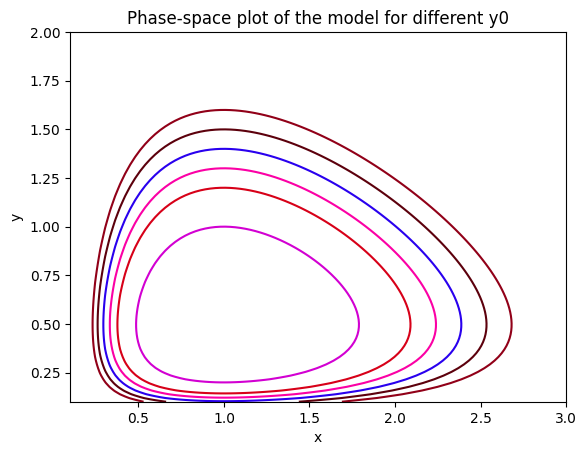

In [ ]:
C = delta*x0 - gamma*np.log(x0) + beta*y0 - alpha*np.log(y0)
def phase_cuve(x, y, y0):
    C = delta*x0 - gamma*np.log(x0) + beta*y0 - alpha*np.log(y0)
    return delta*x - gamma*np.log(x) + beta*y - alpha*np.log(y) - C

x = np.linspace(0.1, 3., 100)
y = np.linspace(0.1, 2., 100)

X, Y = np.meshgrid(x, y)
for r in [1, 1.2, 1.3, 1.4, 1.5, 1.6]:
    Z = phase_cuve(X, Y, r)
    plt.contour(X, Y, Z, levels=[0], colors=[(100*np.sin(r), 0, 100*np.cos(r))])

plt.xlabel("x")
plt.ylabel("y")
plt.title("Phase-space plot of the model for different y0")
plt.show()

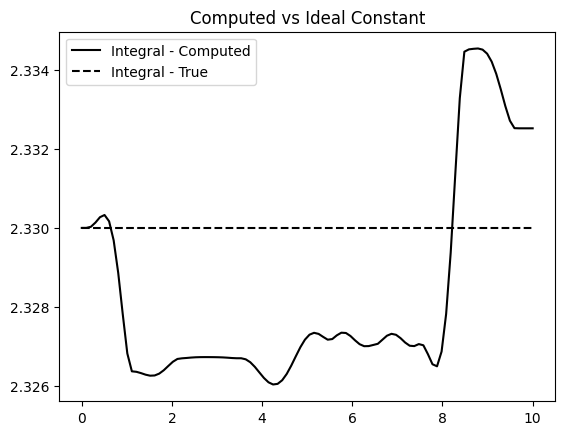

In [ ]:
#To compute the accuracy of solutions, let us plot C(t) which should be constant
tmax = 10
t_e = np.linspace(0, tmax, 100)
x_true, y_true = gen_truedata(t_e)
C_computed = delta*x_true - gamma*np.log(x_true) + beta*y_true - alpha*np.log(y_true)
plt.plot(t_e, C_computed,'k-',label = 'Integral - Computed')
plt.plot(t_e, C_computed[0]*np.ones(len(t_e)),'k--',label = 'Integral - True')
plt.legend()
plt.title('Computed vs Ideal Constant')
plt.show()


In [ ]:
def Lotka_Voltera_eq(t, q):
    x = q[:, 0:1]
    y = q[:, 1:2]
    dx_t = dde.grad.jacobian(q, t, i=0)
    dy_t = dde.grad.jacobian(q, t, i=1)
    return [
        dx_t - alpha * x + beta * x * y,
        dy_t - delta * x * y + gamma * y
    ]

geom = dde.geometry.TimeDomain(0, tmax)

def output_transform_IC(t, q):
    x = q[:, 0:1]
    y = q[:, 1:2]
    return tf.concat([x * tf.tanh(t) + x0, y * tf.tanh(t) + y0], axis=1)

def build_model(num_domain, num_layers, num_neurons, activation):
  data = dde.data.PDE(geom, Lotka_Voltera_eq,
                      [],
                      num_domain=num_domain,
                      num_boundary=8)

  net = dde.nn.FNN([1] + [num_neurons] * num_layers + [2], activation, "Glorot normal")
  net.apply_output_transform(output_transform_IC)
  return dde.Model(data, net)

In [ ]:
#This step takes a very long time to complete! We will not run this cell, and dependent cells, during the lecture
num_train = [16, 128, 1024]
activations = ['tanh', 'sin', 'relu']
num_layers = [1, 2, 3]
params = list(itertools.product(num_train, num_layers, activations))
pinn_solutions = []

t_pred = np.linspace(0, tmax, 100).reshape(-1, 1)

for nt, nl, act in (pbar := tqdm(params)):
  pbar.set_postfix({'Params': (nt, nl, act)})
  model = build_model(nt, nl, 50, act)
  model.compile("adam", lr=8e-5)
  losshistory, train_state = model.train(iterations=50000,
                                         batch_size=2000,
                                         display_every=1e8)
  pinn_solutions.append(model.predict(t_pred))

  0%|          | 0/27 [00:00<?, ?it/s]

Compiling model...
Building feed-forward neural network...
'build' took 0.153006 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.937772 s

Training model...

Step      Train loss              Test loss               Test metric
0         [1.63e-01, 3.02e-02]    [1.63e-01, 3.02e-02]    []  
50000     [1.09e-03, 8.14e-05]    [1.09e-03, 8.14e-05]    []  

Best model at step 50000:
  train loss: 1.17e-03
  test loss: 1.17e-03
  test metric: []

'train' took 55.430788 s

Compiling model...
Building feed-forward neural network...
'build' took 0.042995 s

'compile' took 0.484095 s

Training model...

Step      Train loss              Test loss               Test metric
0         [2.36e-01, 1.31e-02]    [2.36e-01, 1.31e-02]    []  
50000     [2.26e-04, 3.28e-04]    [2.26e-04, 3.28e-04]    []  

Best model at step 50000:
  train loss: 5.55e-04
  test loss: 5.55e-04
  test metric: []

'train' took 46.094025 s

Compiling model...
Building feed-forward neural network...
'build' took 0.044126 s

'compile' took 0.486901 s

Training model...

Step      Train loss              Test loss               Test metri

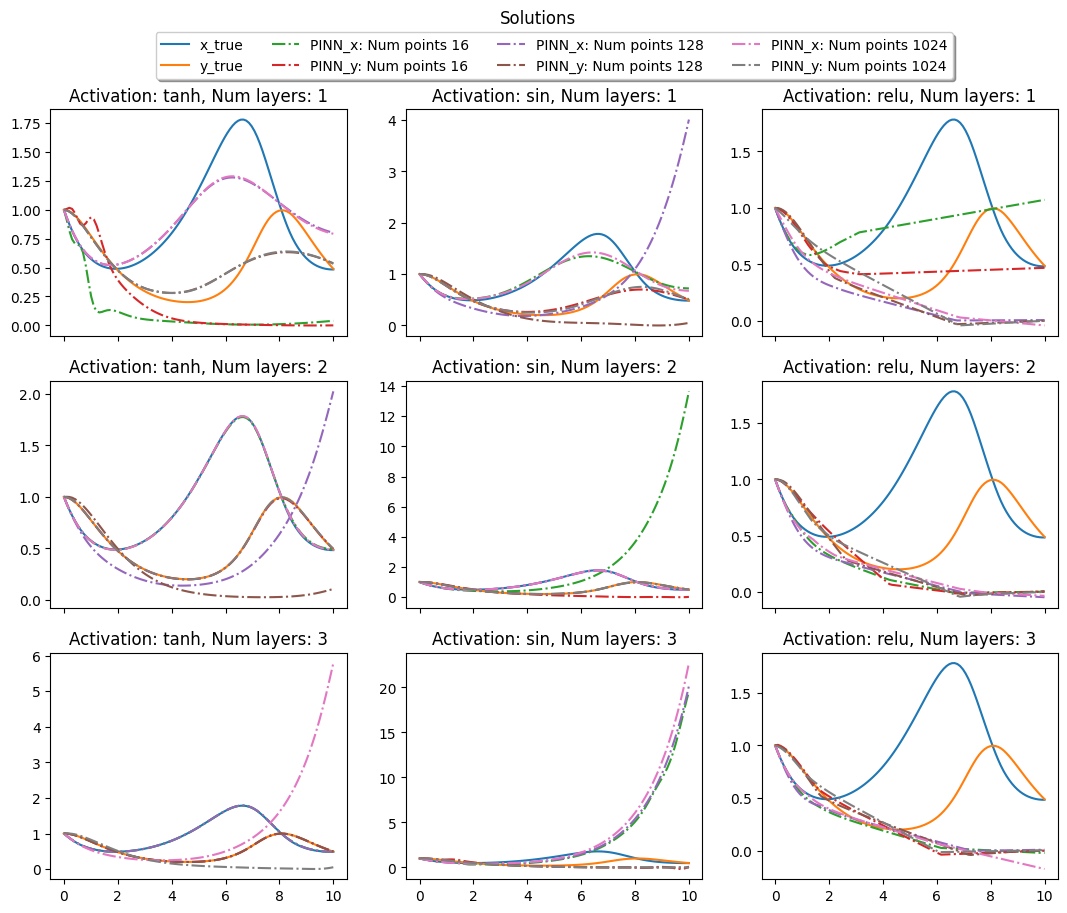

In [ ]:
x_true, y_true = gen_truedata(t_pred.squeeze())

fig, axes = plt.subplots(len(num_layers), len(activations),
                         sharex=True, sharey=False, squeeze=True,
                         figsize=(13, 10))
axes = axes.ravel()
for i, ax in enumerate(axes):
  act = activations[i % len(activations)]
  nl = num_layers[i // len(num_layers)]
  ax.plot(t_pred, x_true, '-', label = 'x_true')
  ax.plot(t_pred, y_true, '-', label = 'y_true')
  for j in range(len(num_train)):
    k = len(activations) * len(num_layers)
    nt = num_train[j]
    ind = i + j * k
    x_pred, y_pred = pinn_solutions[ind].T
    ax.plot(t_pred, x_pred, '-.', label = f'PINN_x: Num points {nt}')
    ax.plot(t_pred, y_pred, '-.', label = f'PINN_y: Num points {nt}')
    ax.set_title(f"Activation: {act}, Num layers: {nl}")
  if i == 1:
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.37),
              ncol=4, fancybox=True, shadow=True)
fig.suptitle("Solutions")
plt.show()

Let's compare the theoretical phase curve (given by $\delta x - \gamma \log(x) +\beta y - \alpha \log(y)=C$) to the predicted phase curve.

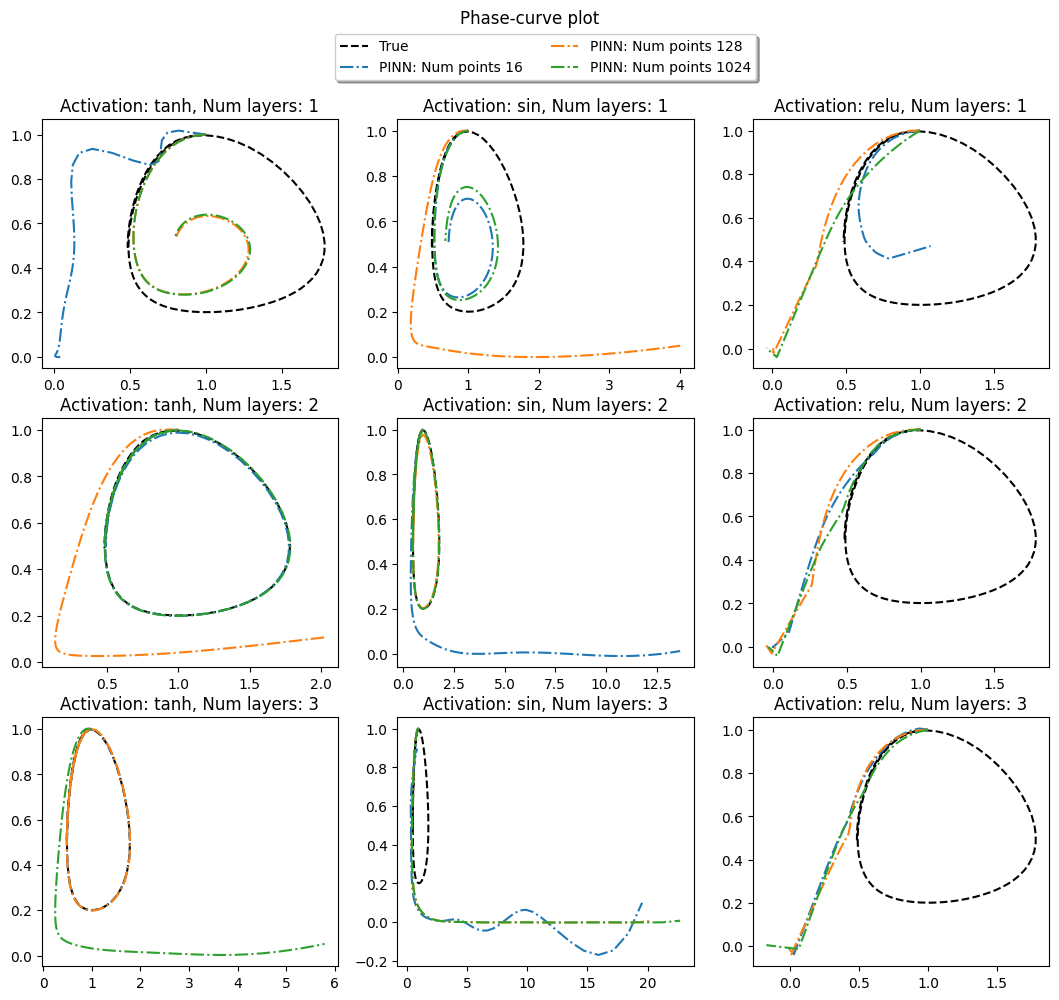

In [ ]:
#Will not be run during the lecture
x_true, y_true = gen_truedata(t_pred.squeeze())

fig, axes = plt.subplots(len(num_layers), len(activations),
                         sharex=False, sharey=False, squeeze=True,
                         figsize=(13, 11))
axes = axes.ravel()
for i, ax in enumerate(axes):
  act = activations[i % len(activations)]
  nl = num_layers[i // len(num_layers)]
  ax.plot(x_true, y_true, 'k--', label = 'True')
  for j in range(len(num_train)):
    k = len(activations) * len(num_layers)
    nt = num_train[j]
    ind = i + j * k
    x_pred, y_pred = pinn_solutions[ind].T
    ax.plot(x_pred, y_pred, '-.', label = f'PINN: Num points {nt}')
    ax.set_title(f"Activation: {act}, Num layers: {nl}")
  if i == 1:
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.37),
              ncol=2, fancybox=True, shadow=True)
fig.suptitle("Phase-curve plot")
plt.show()

<ipython-input-12-cbe7bae38e90>:2: RuntimeWarning: invalid value encountered in log
  return delta * x - gamma * np.log(x) + beta * y - alpha * np.log(y)


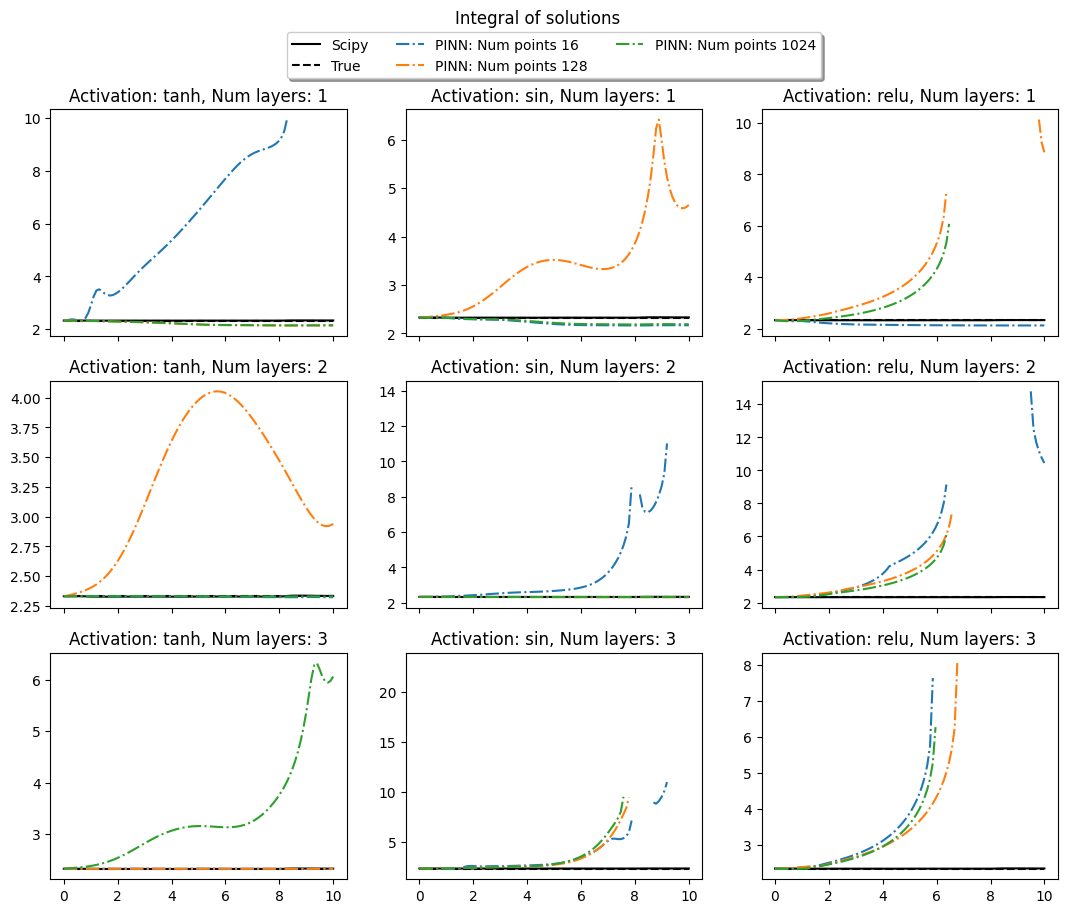

In [ ]:
#Will not be run during the lecture
def integral_sol(x, y):
  return delta * x - gamma * np.log(x) + beta * y - alpha * np.log(y)

x_true, y_true = gen_truedata(t_pred.squeeze())
C_computed = integral_sol(x_true, y_true)

fig, axes = plt.subplots(len(num_layers), len(activations),
                         sharex=True, sharey=False, squeeze=True,
                         figsize=(13, 10))
axes = axes.ravel()
for i, ax in enumerate(axes):
  act = activations[i % len(activations)]
  nl = num_layers[i // len(num_layers)]
  ax.plot(t_pred, C_computed, 'k-', label = 'Scipy')
  ax.plot(t_pred, C_computed[0] * np.ones(len(t_pred)), 'k--', label = 'True')
  for j in range(len(num_train)):
    k = len(activations) * len(num_layers)
    nt = num_train[j]
    ind = i + j * k
    x_pred, y_pred = pinn_solutions[ind].T
    C_pred = integral_sol(x_pred, y_pred)
    ax.plot(t_pred, C_pred, '-.', label = f'PINN: Num points {nt}')
    ax.set_title(f"Activation: {act}, Num layers: {nl}")
  if i == 1:
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.37),
              ncol=3, fancybox=True, shadow=True)
fig.suptitle("Integral of solutions")
plt.show()

## Lorenz problem

We know from from experiments that PINNs have hard time learnig the Lorenz' system
\begin{align}
\frac{dx}{dt} & = \sigma(y-x)\\
\frac{dy}{dt} & =x(\rho -z) -y \\
\frac{dz}{dt} & = xy - \beta z\\\tag{5}
\end{align}
with parameters
$$
\sigma=10\quad , \quad \beta=\frac{8}{3} \quad , \quad \rho= 28,
$$
and initial conditions
$$
x(0)= 0\quad , \quad y(0)= 1\quad , \quad z(0)=1.05.
$$
What will do this time is to provide the PINN model with data and see that helps.

In [ ]:
#OK to run from here
# Lorenz parameters
sigma, beta, rho = 10, 2.667, 28
# initial conditions x(0), y(0) and z(0)
x0, y0, z0 = 0, 1, 1.05

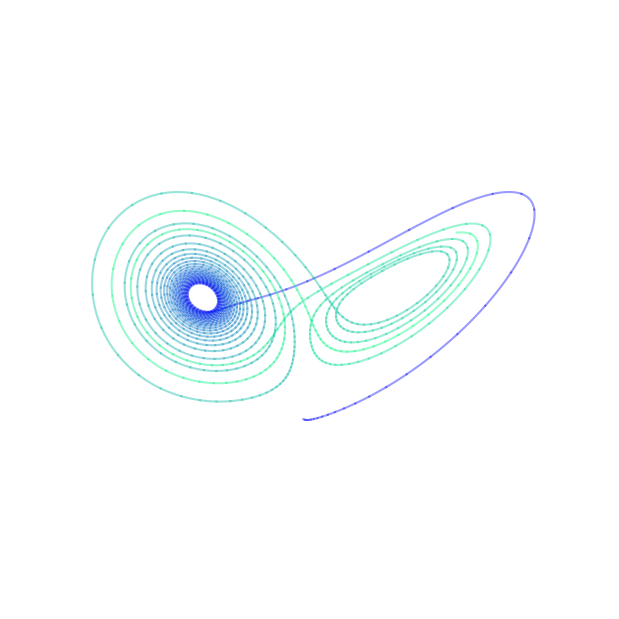

In [ ]:
# Maximum time and total number of time points.
tmax, n = 20, 10000

def lorenz(t, X, sigma, beta, rho):
    """The Lorenz equations."""
    x, y, z = X
    dx_dt = sigma*(y - x)
    dy_dt = rho*x - y - x*z
    dz_dt = -beta*z + x*y
    return dx_dt, dy_dt, dz_dt
# Integrate the Lorenz equations.
lorenz_scipy = solve_ivp(lorenz, (0, tmax), (x0, y0, z0),
                         args=(sigma, beta, rho),
                 dense_output=True)

# the reference function
def lorenz_ref(t):
    x, y, z = lorenz_scipy.sol(t.flatten())
    return np.vstack((x, y, z)).T

# Interpolate solution onto the time grid, t.
t = np.linspace(0, tmax, n)
x, y, z = lorenz_ref(t).T

# Plot the Lorenz attractor using a Matplotlib 3D projection.
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(projection='3d')
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

# Make the line multi-coloured by plotting it in segments of length s which
# change in colour across the whole time series.
s = 10
cmap = plt.cm.winter
for i in range(0,n-s,s):
    ax.plot(x[i:i+s+1], y[i:i+s+1], z[i:i+s+1], color=cmap(i/n), alpha=0.4)


# Remove all the axis clutter, leaving just the curve.
ax.set_axis_off()

plt.show()

A function that generates reference data for Lorenz equation

In [ ]:
def lorenz_ref(t):
    x, y, z = lorenz_scipy.sol(t)
    return np.vstack((x, y, z)).T

def lorenz_data(num_pts=200):
    observe_t = np.random.uniform(0, tmax, num_pts)
    return observe_t.reshape(num_pts, 1), lorenz_ref(observe_t)

We now put the known points from the numerical solution of Lorenz equation into DeepXDE, to try to make the PINN to satisfy Lorenz equation more accurately

In [ ]:
def lorenz_deepxde(t, u):
    x = u[:, 0:1]
    y = u[:, 1:2]
    z = u[:, 2:3]
    x_t = dde.grad.jacobian(u, t, i=0)
    y_t = dde.grad.jacobian(u, t, i=1)
    z_t = dde.grad.jacobian(u, t, i=2)
    return [x_t - sigma * (y - x),
            y_t - rho * x + y + x * z,
            z_t + beta * z - x * y]

geom = dde.geometry.TimeDomain(0., tmax)

def boundary_ic(t, _):
    return dde.utils.isclose(t[0], 0.0)

ic1 = dde.icbc.IC(geom, lambda t: x0, boundary_ic, component=0)
ic2 = dde.icbc.IC(geom, lambda t: y0, boundary_ic, component=1)
ic3 = dde.icbc.IC(geom, lambda t: z0, boundary_ic, component=2)

# we use 1000 data points
# ob_y has three components corresponding to observed values (x,y,z)
ob_t, ob_y = lorenz_data(1000)
observe_x = dde.icbc.PointSetBC(ob_t, ob_y[:, 0:1], component=0)
observe_y = dde.icbc.PointSetBC(ob_t, ob_y[:, 1:2], component=1)
observe_z = dde.icbc.PointSetBC(ob_t, ob_y[:, 2:3], component=2)

data = dde.data.PDE(
    geom,
    lorenz_deepxde,
    bcs=[observe_x, observe_y, observe_z],
    num_domain=1000,
    # num_boundary=2,
    anchors=ob_t,
    )

net = dde.nn.FNN([1] + [60]*3 + [3],
        activation="sin",
        kernel_initializer="Glorot uniform",
      )

def output_transform(t, u):
    x = u[:, 0:1]
    y = u[:, 1:2]
    z = u[:, 2:3]
    return tf.concat([x * tf.tanh(t) + x0,
                      y * tf.tanh(t) + y0,
                      z * tf.tanh(t) + z0], axis=1)

net.apply_output_transform(output_transform)
model = dde.Model(data, net)

Compiling model...
Building feed-forward neural network...
'build' took 0.203395 s

'compile' took 1.353703 s

Training model...

0         [9.96e+00, 1.57e+01, 1.59e+00, 6.50e+01, 8.29e+01, 6.13e+02]    [9.96e+00, 1.57e+01, 1.59e+00, 6.50e+01, 8.29e+01, 6.13e+02]    []  
1000      [8.97e+00, 2.56e+01, 1.15e+02, 5.17e+01, 5.26e+01, 1.81e+02]    [8.97e+00, 2.56e+01, 1.15e+02, 5.17e+01, 5.26e+01, 1.81e+02]    []  
2000      [6.86e+00, 6.38e+01, 5.03e+01, 2.63e+01, 3.53e+01, 8.75e+01]    [6.86e+00, 6.38e+01, 5.03e+01, 2.63e+01, 3.53e+01, 8.75e+01]    []  
3000      [1.43e+00, 1.33e+01, 4.31e+01, 2.48e+01, 3.36e+01, 6.77e+01]    [1.43e+00, 1.33e+01, 4.31e+01, 2.48e+01, 3.36e+01, 6.77e+01]    []  
4000      [1.15e+00, 1.34e+01, 3.35e+01, 2.46e+01, 3.29e+01, 5.60e+01]    [1.15e+00, 1.34e+01, 3.35e+01, 2.46e+01, 3.29e+01, 5.60e+01]    []  
5000      [2.26e+00, 1.44e+01, 3.20e+01, 2.07e+01, 2.82e+01, 5.38e+01]    [2.26e+00, 1.44e+01, 3.20e+01, 2.07e+01, 2.82e+01, 5.38e+01]    []  
6000      [2

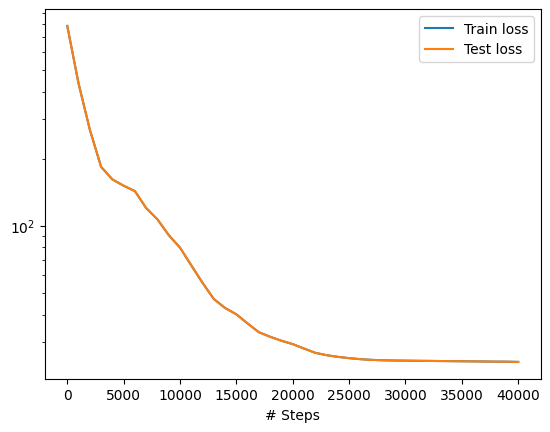

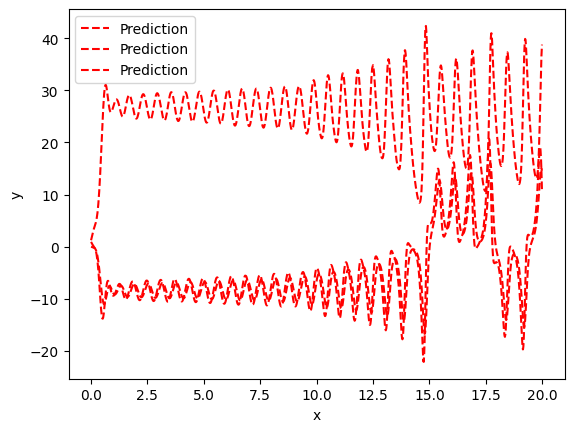

In [ ]:
#This cell takes about 10 minutes to run on a CPU! This cell and its dependencies may be skipped during the lecture
model.compile(
    optimizer = "adam", lr=1e-4,
    loss_weights = [1e-1]*3 + [1]*3,
)

losshistory, train_state = model.train(iterations=40000)
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

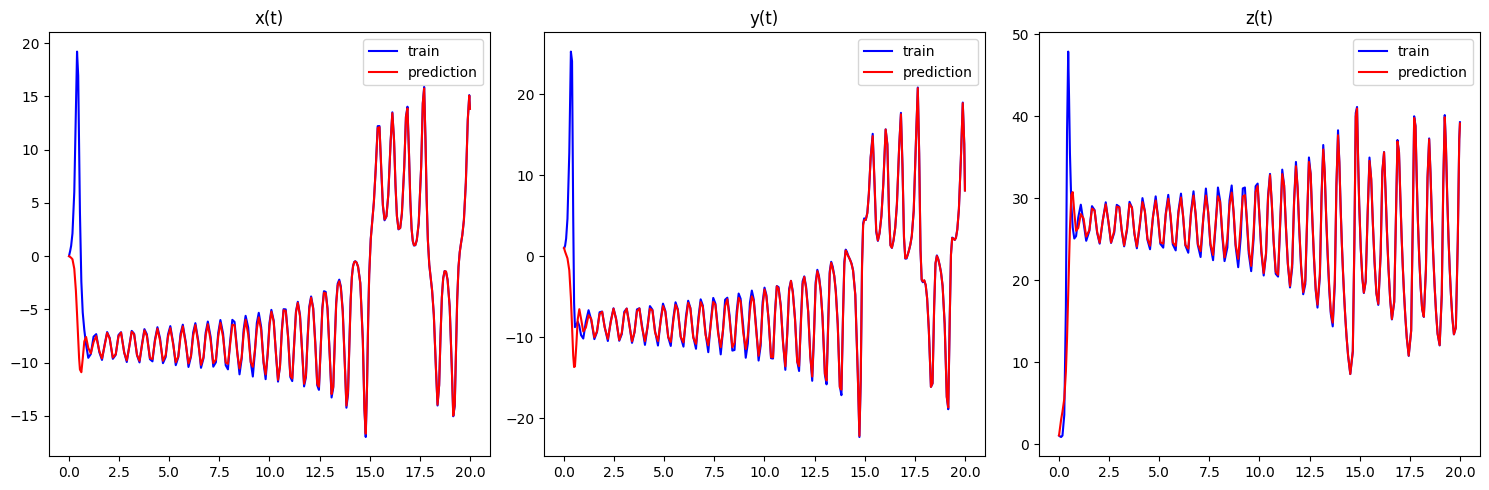

In [ ]:
# This cell is dependent on the learning cell above; will not be run ruding the lecture
# The predicted solution using DeepXDE
lorenz_predict = model.predict(lorenz_scipy.t.reshape(lorenz_scipy.t.shape[0],1))

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# x(t)
axs[0].plot(lorenz_scipy.t, lorenz_scipy.y[0], label='train', color='b')
axs[0].plot(lorenz_scipy.t, lorenz_predict[:,0], label='prediction', color='red')
axs[0].set_title('x(t)')
axs[0].legend()

# y(t)
axs[1].plot(lorenz_scipy.t, lorenz_scipy.y[1], label='train', color='b')
axs[1].plot(lorenz_scipy.t, lorenz_predict[:,1], label='prediction', color='red')
axs[1].set_title('y(t)')
axs[1].legend()

# z(t)
axs[2].plot(lorenz_scipy.t, lorenz_scipy.y[2], label='train', color='b')
axs[2].plot(lorenz_scipy.t, lorenz_predict[:,2], label='prediction', color='red')
axs[2].set_title('z(t)')
axs[2].legend()

plt.tight_layout()

plt.show()

<a id="3"></a>
## Kepler problem

### Two-body system

The 2D **Kepler problem** describes the motion of two point masses under the influence of gravitational attraction in a two-dimensional plane. Let's call the two masses $m_1$ and $m_2$, and let $\vec{r_1}$ and $\vec{r_2}$ be the radial vectors from the origin $O$, as in the picture below.

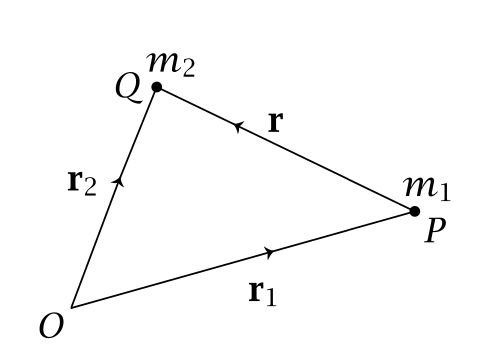

The motion of $m_1$ and $m_2$ is described by the two differential equations
\begin{equation}
\frac{d^2 r_1}{dt^2} =  \frac{G m_2}{r^3}\vec{r} \qquad \text{and} \qquad \frac{d^2 r_2}{dt^2} =  -\frac{G m_1}{r^3}\vec{r},\tag{6}
\end{equation}
where $\vec{r} = \vec{r_2}-\vec{r_1}$ and $r=|\vec{r}|$.

Write $r_1=(x_1,y_1)$ and $r_2=(x_2,y_2)$. Then  (6) is equivalent to  
 $$\begin{cases}
\ddot{x}_1 = G m_2 \frac{x_2 - x_1}{r^3} \\
\ddot{y}_1 = G m_2 \frac{y_2 - y_1}{r^3}
 \end{cases}\quad \text{and} \quad
   \begin{cases} \ddot{x}_2 = -G m_1 \frac{x_2 - x_1}{r^3} \\
    \ddot{y}_2 = -G m_1 \frac{y_2 - y_1}{r^3} .
   \end{cases}\tag{7}$$


We impose the initial positions
$$
r_1(0)=(0,0) \qquad , \qquad r_2(0)=(0,0.2)
,$$
and initial velocities
$$
\dot{r_1}(0)=(0,1) \qquad , \qquad \dot{r_2}(0)=(0,-1)
.$$

The equations can be reformulated using the state vector $$s = \left[x_1\ y_1\ x_2\ y_2\ \dot{x}_1\ \dot{y}_1\ \dot{x}_2\ \dot{y}_2\right],$$
and computing its derivative
$$
\dot{s} = \left[\dot{x}_1\ \dot{y}_1\ \dot{x}_2\ \dot{y}_2\ \ddot{x}_1\ \ddot{y}_1\ \ddot{x}_2\ \ddot{y}_2\right]
$$
in terms of $s$.

This problem is exactly as the one considered before; we now add the values of the state vector (partial or full) computed from the numerical solution, to improve the solution of Kepler's problem using DeepXDE.

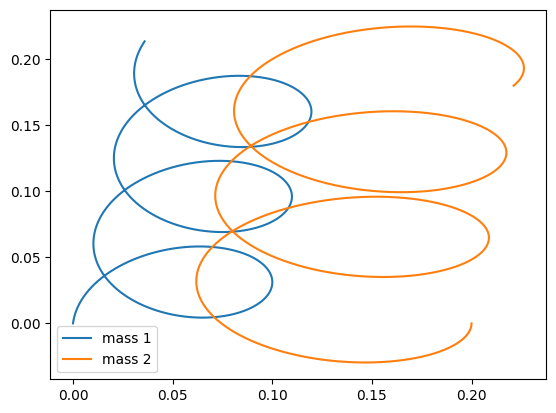

In [ ]:
G = 1.0  # physical constant ~ 6.67430e-20
m_1, m_2 = 1.5, 1.0

r_1_0 = np.array((0, 0))        # initial loc r1
r_2_0 = np.array((0.2, 0))      # initial loc r2
dotr_1_0 = np.array((0.1, 1.2))   # initial vel r1
dotr_2_0 = np.array((0, -0.8))    # initial vel r2

# the initial condition
s0 = np.hstack((r_1_0, r_2_0, dotr_1_0, dotr_2_0))

# the equations
def kepler_system(t, s):
  """
  s is the state vector and it has 8 components,
  the first two represent r_1 (the position vector of m_1),
  and the next two represent r_2 (the position vector of m_2)
  """
  r_1 = s[:2]
  r_2 = s[2:4]

  # define the derivative of the state vector
  sdot = np.zeros_like(s)
  sdot[:4] = s[4:]

  r = np.linalg.norm(r_2 - r_1)
  ddot = G * (r_2 - r_1) / r ** 3
  ddotr_1 = m_2 * ddot
  ddotr_2 = -m_1 * ddot

  sdot[4:6] = ddotr_1
  sdot[6:] = ddotr_2
  return sdot

t_0 = 0  # seconds
t_f = 0.5  # seconds
t_points = np.linspace(t_0, t_f, 5000)

kepler_scipy = solve_ivp(kepler_system, [t_0, t_f], s0, t_eval=t_points, dense_output=True)

t = kepler_scipy.t
s = kepler_scipy.y
r_1 = s[:2,:]  # km
r_2 = s[2:4,:]  # km
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(r_1[0,:], r_1[1,:], label="mass 1")
ax.plot(r_2[0,:], r_2[1,:], label="mass 2")
ax.legend()
plt.show()

Compiling model...
Building feed-forward neural network...
'build' took 0.063451 s

'compile' took 3.071392 s

Training model...

Step      Train loss                                                                                                                  Test loss                                                                                                                   Test metric   
0         [4.28e-01, 8.02e-03, 8.86e-01, 2.52e-02, 1.00e-02, 1.44e+00, 0.00e+00, 6.40e-01, 9.06e-03, 1.15e-02, 2.98e-03, 6.71e-03]    [4.30e-01, 7.93e-03, 8.91e-01, 2.51e-02, 1.00e-02, 1.44e+00, 0.00e+00, 6.40e-01, 9.06e-03, 1.15e-02, 2.98e-03, 6.71e-03]    [6.83e-01]    
2000      [1.82e-03, 8.37e-03, 2.58e-03, 1.16e-02, 6.61e-05, 4.00e-04, 3.44e-05, 5.21e-04, 5.94e-03, 4.70e-03, 9.57e-03, 9.92e-03]    [1.83e-03, 7.49e-03, 2.56e-03, 1.10e-02, 6.61e-05, 4.00e-04, 3.44e-05, 5.21e-04, 5.94e-03, 4.70e-03, 9.57e-03, 9.92e-03]    [6.83e-01]    
4000      [1.87e-03, 4.64e-03, 2.42e-03, 6.08e-03, 

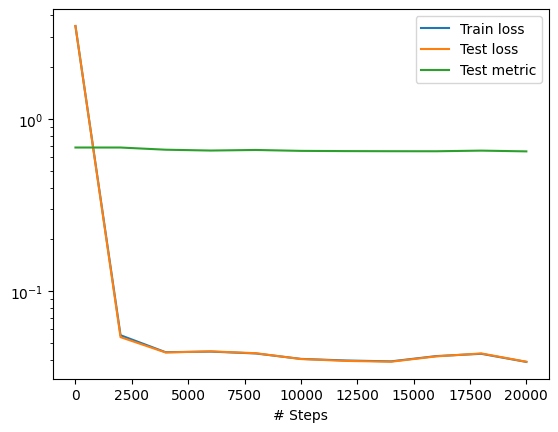

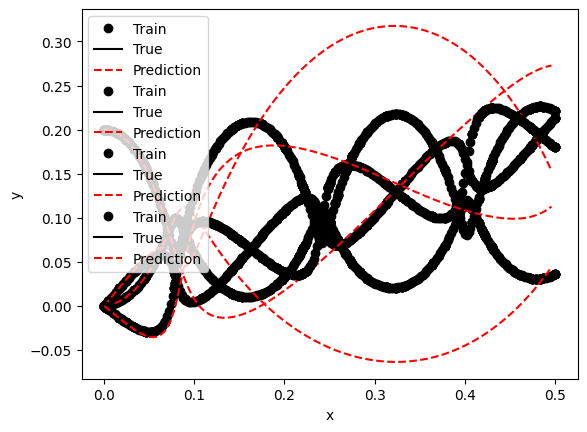

In [ ]:
def kepler_deepxde(t, s):
    # s=[x1,y1,x2,y2]
    x1, y1, x2, y2 = s[:,0:1], s[:,1:2], s[:,2:3], s[:,3:4]
    r3 = tf.norm(s[:, 2: 4] - s[:, :2], axis=1, keepdims=True)**3

    # equations in (7)
    z1 = dde.grad.hessian(x1, t) - G * m_2 * (x2 - x1) / r3
    z2 = dde.grad.hessian(y1, t) - G * m_2 * (y2 - y1) / r3
    z3 = dde.grad.hessian(x2, t) + G * m_1 * (x2 - x1) / r3
    z4 = dde.grad.hessian(y2, t) + G * m_1 * (y2 - y1) / r3

    return [z1, z2, z3, z4]

def boundary_ic(t, on_initial):
    return dde.utils.isclose(t[0], 0.0)

# velocity initial conditions
def bc_func1(t, y, _):
    # x_1'(0)
    return dde.grad.jacobian(y, t, i=0) - dotr_1_0[0]
def bc_func2(t, y, _):
    # y_1'(0)
    return dde.grad.jacobian(y, t, i=1) - dotr_1_0[1]
def bc_func3(t, y, _):
    # x_2'(0)
    return dde.grad.jacobian(y, t, i=2) - dotr_2_0[0]
def bc_func4(t, y, _):
    # y_2'(0)
    return dde.grad.jacobian(y, t, i=3) - dotr_2_0[1]

def kepler_ref(t):
    return kepler_scipy.sol(t.flatten()).T[:, 0:4]

# position initial conditions
geom = dde.geometry.TimeDomain(t_0, t_f)

bc1 = dde.icbc.OperatorBC(geom, bc_func1, boundary_ic)
bc2 = dde.icbc.OperatorBC(geom, bc_func2, boundary_ic)
bc3 = dde.icbc.OperatorBC(geom, bc_func3, boundary_ic)
bc4 = dde.icbc.OperatorBC(geom, bc_func4, boundary_ic)

ibc = [bc1, bc2, bc3, bc4]

# To improve PINNs, let's feed some points with known solution
pointset_t = np.random.uniform(t_0, t_f, size=64)
pointset_sol = kepler_ref(pointset_t).T
pointsets = [dde.icbc.PointSetBC(pointset_t[:, None], ps[:, None], component=i)
             for i, ps in enumerate(pointset_sol)]

ibc = ibc + pointsets

def output_transform_hard_IC(t, y):
    x1, y1 = y[:, 0:1], y[:, 1:2]
    x2, y2 = y[:, 2:3], y[:, 3:4]

    factor = tf.tanh(t)

    return tf.concat([x1 * factor + r_1_0[0],
                      y1 * factor + r_1_0[1],
                      x2 * factor + r_2_0[0],
                      y2 * factor + r_2_0[1]],
                      axis=-1)

net = dde.nn.FNN([1] + [50] * 3 + [4], "tanh", "Glorot normal")
net.apply_output_transform(output_transform_hard_IC)  # initial conditions are applied as hard constraints

data = dde.data.TimePDE(
    geom, kepler_deepxde,
    ic_bcs=ibc,
    num_domain=256,
    num_boundary=10,
    # num_initial=10,
    solution=kepler_ref,
    num_test=128,
)

sampler = dde.callbacks.PDEPointResampler(period=2500,
                                          pde_points=False,
                                          bc_points=False)

model = dde.Model(data, net)
model.compile("adam", lr=1e-3,
              loss_weights=[1e-3] * 4 + [1] * 8,
              metrics=["l2 relative error"])
losshistory, train_state = model.train(iterations=20000, display_every=2000,
                                       batch_size=1000, callbacks=[sampler])
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

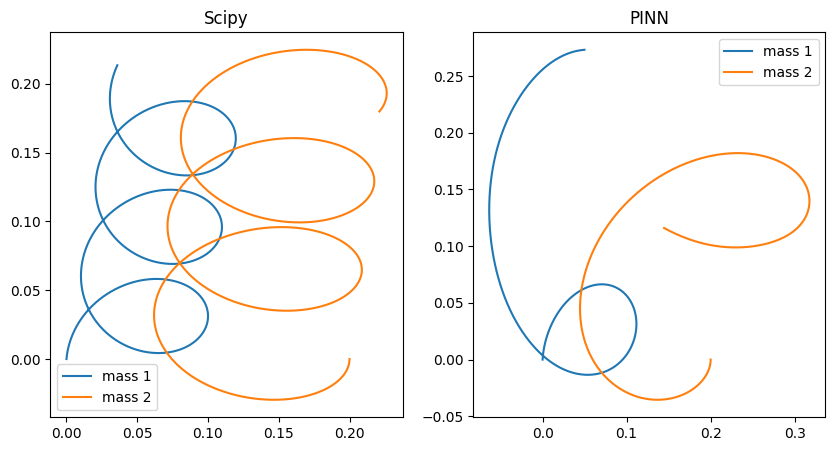

In [ ]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)

t = kepler_scipy.t
s = kepler_scipy.y
r_1 = s[:2,:]  # km
r_2 = s[2:4,:]  # km

ax.plot(r_1[0,:], r_1[1,:], label="mass 1")
ax.plot(r_2[0,:], r_2[1,:], label="mass 2")
ax.set_title("Scipy")
ax.legend()

ax = fig.add_subplot(122)

s = model.predict(t[:, None])
r_1 = s[:, :2]  # km
r_2 = s[:, 2:4]  # km

ax.set_title("PINN")
ax.plot(r_1[:, 0], r_1[:, 1], label="mass 1")
ax.plot(r_2[:, 0], r_2[:, 1], label="mass 2")
ax.legend()

plt.show()

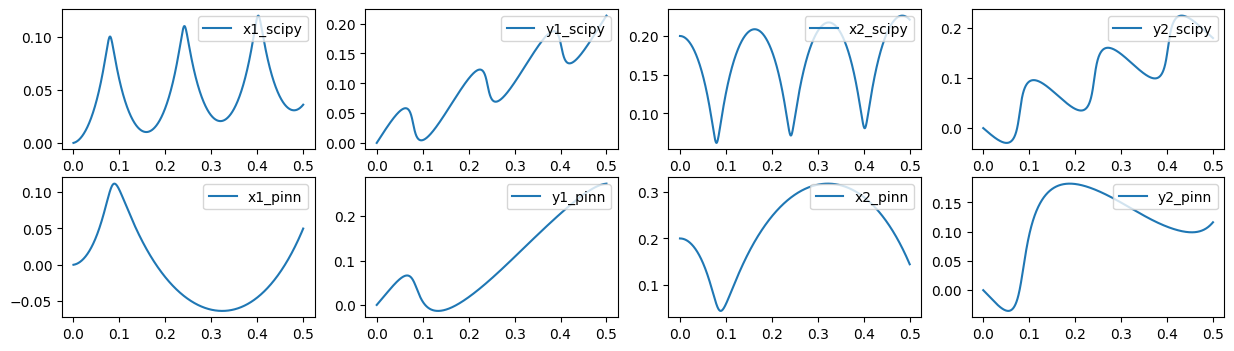

In [ ]:
fig = plt.figure(figsize=(15,4))

leg_loc = 'upper right'
t = kepler_scipy.t
s = kepler_scipy.y

ax = fig.add_subplot(241)
ax.plot(t, s[0,:], label="x1_scipy")
ax.legend(loc=leg_loc)

ax = fig.add_subplot(242)
ax.plot(t, s[1,:], label="y1_scipy")
ax.legend(loc=leg_loc)

ax = fig.add_subplot(243)
ax.plot(t, s[2,:], label="x2_scipy")
ax.legend(loc=leg_loc)

ax = fig.add_subplot(244)
ax.plot(t, s[3,:], label="y2_scipy")
ax.legend(loc=leg_loc)

s = model.predict(t[:, None])

ax = fig.add_subplot(245)
ax.plot(t, s[:, 0], label="x1_pinn")
ax.legend(loc=leg_loc)

ax = fig.add_subplot(246)
ax.plot(t, s[:, 1], label="y1_pinn")
ax.legend(loc=leg_loc)

ax = fig.add_subplot(247)
ax.plot(t, s[:, 2], label="x2_pinn")
ax.legend(loc=leg_loc)

ax = fig.add_subplot(248)
ax.plot(t, s[:, 3], label="y2_pinn")
ax.legend(loc=leg_loc)

plt.show()

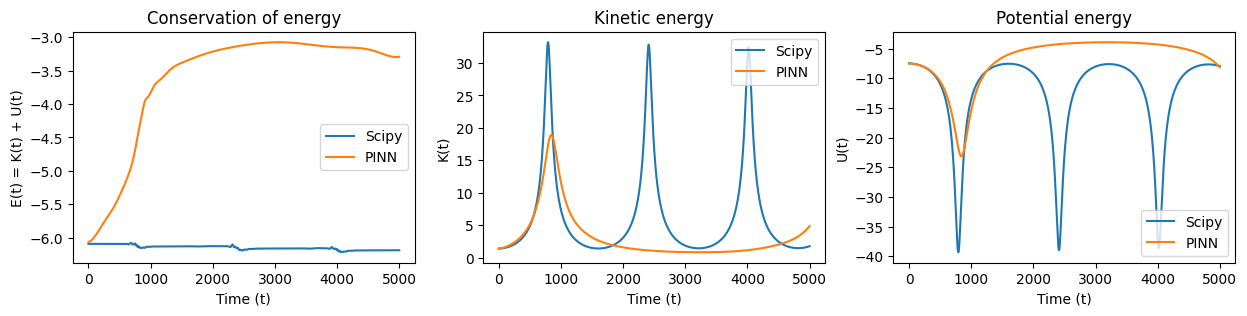

In [ ]:
def total_energy(t, s):
    x1, y1, x2, y2 = s[:,0:1], s[:,1:2], s[:,2:3], s[:,3:4]
    r = tf.norm(s[:, 0:2] - s[:, 2:4], axis=1, keepdims=True)

    # velocity
    vx1 = dde.grad.jacobian(x1, t)
    vy1 = dde.grad.jacobian(y1, t)
    vx2 = dde.grad.jacobian(x2, t)
    vy2 = dde.grad.jacobian(y2, t)

    K = 0.5 * (m_1 * (vx1**2 + vy1**2) + m_2 * (vx2**2 + vy2**2))
    U = - G * m_1 * m_2 / r

    return K, U

K_dde, U_dde = model.predict(t[:, None], operator=total_energy)
K_dde, U_dde = K_dde.squeeze(), U_dde.squeeze()

def total_energy_scipy(scipy_solution):
    x1, y1, x2, y2, vx1, vy1, vx2, vy2 = scipy_solution
    r = np.sqrt((x1 - x2)**2 + (y1 - y2)**2)

    K = 0.5 * (m_1 * (vx1**2 + vy1**2) + m_2 * (vx2**2 + vy2**2))
    U = - G * m_1 * m_2 / r

    return K, U

K_scipy, U_scipy = total_energy_scipy(kepler_scipy.y)

plt.figure(figsize=(15, 3))

plt.subplot(131)
plt.plot(K_scipy + U_scipy, label='Scipy')
plt.plot(K_dde + U_dde, label='PINN')
plt.title('Conservation of energy')
plt.xlabel('Time (t)')
plt.ylabel('E(t) = K(t) + U(t)')
plt.legend()

plt.subplot(132)
plt.plot(K_scipy, label='Scipy')
plt.plot(K_dde, label='PINN')
plt.title('Kinetic energy')
plt.xlabel('Time (t)')
plt.ylabel('K(t)')
plt.legend()

plt.subplot(133)
plt.plot(U_scipy, label='Scipy')
plt.plot(U_dde, label='PINN')
plt.title('Potential energy')
plt.xlabel('Time (t)')
plt.ylabel('U(t)')
plt.legend()

plt.show()

### Single-body Kepler problem

In this second example, we compute the  motion of mass $m_2$ relative to mass $m_1$. For example, $m_1$ represents the Earth and $m_2$ represents a satellite. The equation of motion is given by

$$ \frac{d^2\vec{r}}{dt^2} = -Gm_1\frac{\vec{r}}{r^3}.$$

We will now add the values from numerical solvers as the known data in order to improve the solution of Kepler problem

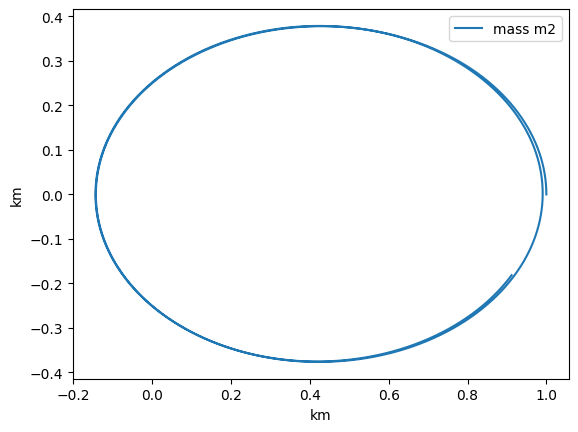

In [ ]:
G = 1  # km**3/(kg * s**2)
m_1 = 1e2  # kg
m_2 = 1e-2  # kg
mu = G * m_1

r_0 = np.array((1, 0))  # km
v_0 = np.array((0, 5.0))  # km/s
y_0 = np.hstack((r_0, v_0))

def kepler_single(t, y):

    # Get the three position components
    r_vec = y[:2]

    # Create the derivative vector and copy the velocities into it
    ydot = np.zeros_like(y)
    ydot[:2] = y[2:]

    # Calculate the accelerations
    r = np.sqrt(np.sum(np.square(r_vec)))
    a_vec = -mu * r_vec / r ** 3
    ydot[2:] = a_vec

    return ydot

t_0 = 0  # seconds
t_f = 0.5  # seconds, period of one orbit
t = np.linspace(t_0, t_f, 10000)
sol_kepler_single = solve_ivp(kepler_single, [t_0, t_f], y_0, t_eval=t, dense_output=True)

y = sol_kepler_single.y.T
r = y[:, :2]  # km
v = y[:, 2:]  # km/s

plt.plot(r[:, 0], r[:, 1], label="mass m2")
plt.xlabel("km")
plt.ylabel("km")

plt.legend()
plt.show()

Compiling model...
Building feed-forward neural network...
'build' took 0.045311 s

'compile' took 0.997108 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric   
0         [8.87e+01, 2.02e-01, 0.00e+00, 2.50e+01, 2.81e-01, 7.99e-02]    [8.88e+01, 2.00e-01, 0.00e+00, 2.50e+01, 2.81e-01, 7.99e-02]    [8.00e-01]    
2000      [2.22e-01, 2.65e+00, 8.39e-02, 6.80e-01, 6.50e-01, 4.44e-01]    [2.06e-01, 2.58e+00, 8.39e-02, 6.80e-01, 6.50e-01, 4.44e-01]    [1.33e+00]    
4000      [2.65e-01, 2.23e+00, 4.29e-02, 5.91e-01, 5.33e-01, 3.99e-01]    [2.28e-01, 2.16e+00, 4.29e-02, 5.91e-01, 5.33e-01, 3.99e-01]    [1.24e+00]    
6000      [1.65e-01, 1.36e+00, 1.64e-02, 3.70e-01, 3.60e-01, 3.15e-01]    [1.66e-01, 1.33e+00, 1.64e-02, 3.70e-01, 3.60e-01, 3.15e-01]    [1.06e+00]    
8000      [1.48e-01, 1.14e+00, 1.66e-02, 3.14e-01, 3.19e-01, 2.91e-01]    [1.40e-01, 1.12e+00, 1.66e-02, 

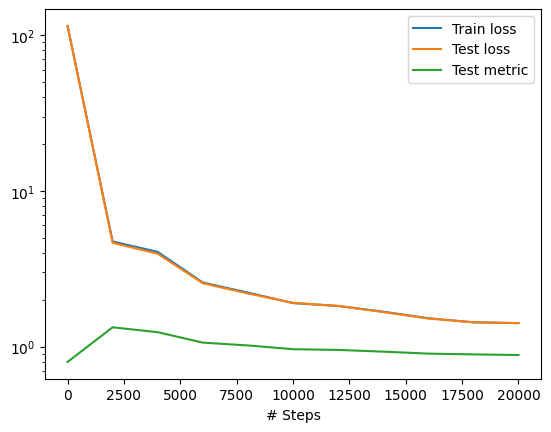

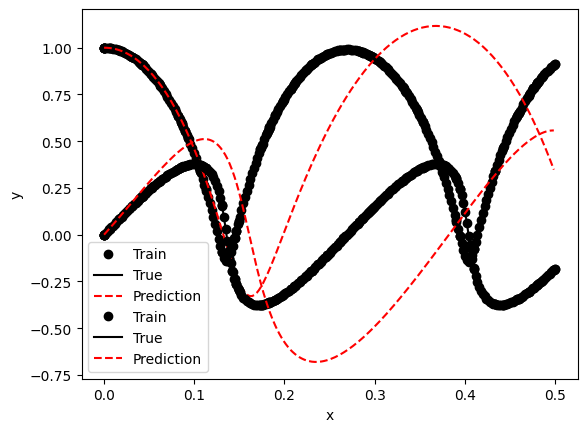

In [ ]:
def kepler_single_deepxde(t, y):
    r = tf.norm(y, axis=1, keepdims=True)
    y0_tt = dde.grad.hessian(y, t, component=0)
    y1_tt = dde.grad.hessian(y, t, component=1)
    return [y0_tt + mu * y[:, 0:1] / r**3,
            y1_tt + mu * y[:, 1:2] / r**3]

def boundary_bc(t, on_initial):
    return dde.utils.isclose(t[0], 0.0)

# velocity initial conditions
def bc_func1(t, y, _):
    # x_1'(0)
    return dde.grad.jacobian(y, t, i=0) - v_0[0]
def bc_func2(t, y, _):
    # y_1'(0)
    return dde.grad.jacobian(y, t, i=1) - v_0[1]

def kepler_ref(t):
    return sol_kepler_single.sol(t.flatten())[:2].T

# position initial conditions
geom = dde.geometry.TimeDomain(t_0, t_f)

bc1 = dde.icbc.OperatorBC(geom, bc_func1, boundary_bc)
bc2 = dde.icbc.OperatorBC(geom, bc_func2, boundary_bc)

ibc = [bc1, bc2]

# To improve PINNs, let's feed some points with known solution
pointset_t = np.random.uniform(t_0, t_f, size=64)
pointset_sol = kepler_ref(pointset_t).T
pointsets = [dde.icbc.PointSetBC(pointset_t[:, None], ps[:, None], component=i)
             for i, ps in enumerate(pointset_sol)]

ibc = ibc + pointsets

data = dde.data.TimePDE(
    geom, kepler_single_deepxde,
    ic_bcs=ibc,
    num_domain=256,
    num_boundary=4,
    solution=kepler_ref,
    num_test=200,
)

def output_transform_hard_IC(t, y):
    y1 = y[:, 0:1]
    y2 = y[:, 1:2]
    factor = tf.tanh(t)
    return tf.concat([y1 * factor + r_0[0],
                      y2 * factor + r_0[1]], axis=1)

net = dde.nn.FNN([1] + [50] * 3 + [2], "sin", "Glorot uniform")
net.apply_output_transform(output_transform_hard_IC)

model = dde.Model(data, net)
model.compile("adam", lr=5e-4,
              loss_weights=[1e-2]*2 + [1]*4,
              metrics=["l2 relative error"])
losshistory, train_state = model.train(iterations=20000, display_every=2000)
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

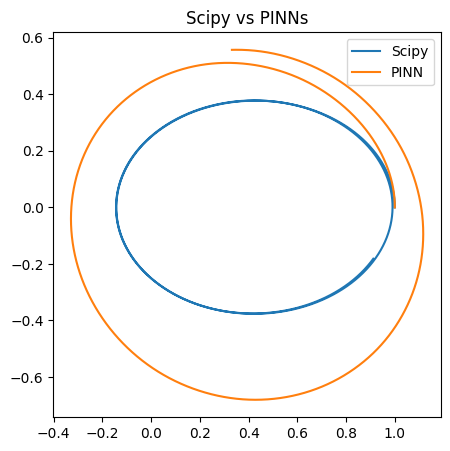

In [ ]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

t = sol_kepler_single.t
s = sol_kepler_single.y
r_1 = s[:2,:].T  # km

s = model.predict(t[:, None])

ax.plot(r_1[:, 0], r_1[:, 1], label="Scipy")
ax.plot(s[:, 0], s[:, 1], label="PINN")
ax.set_title("Scipy vs PINNs")
ax.legend()
plt.show()

### Question
Calculate and plot the total energy of single body system (see example above on the two body system)

In [ ]:
#@title ###Answer

def total_energy(t, y):
    x1, y1 = y[:, 0:1], y[:, 1:2]
    r = tf.norm(y, axis=1, keepdims=True)

    # velocity
    vx1 = dde.grad.jacobian(x1, t)
    vy1 = dde.grad.jacobian(y1, t)

    K = 0.5 * (m_2 * (vx1**2 + vy1**2))
    U = - G * m_1 * m_2 / r

    return K, U

K_dde, U_dde = model.predict(t[:, None], operator=total_energy)
K_dde, U_dde = K_dde.squeeze(), U_dde.squeeze()

def total_energy_scipy(scipy_solution):
    x1, y1, vx1, vy1 = scipy_solution
    r = np.sqrt(x1**2 + y1**2)

    K = 0.5 * m_2 * (vx1**2 + vy1**2)
    U = - G * m_1 * m_2 / r

    return K, U

K_scipy, U_scipy = total_energy_scipy(sol_kepler_single.y)

plt.figure(figsize=(15, 3))

plt.subplot(131)
plt.plot(K_scipy + U_scipy, label='Scipy')
plt.plot(K_dde + U_dde, label='PINN')
plt.title('Conservation of energy')
plt.xlabel('Time (t)')
plt.ylabel('E(t) = K(t) + U(t)')
plt.legend()

plt.subplot(132)
plt.plot(K_scipy, label='Scipy')
plt.plot(K_dde, label='PINN')
plt.title('Kinetic energy')
plt.xlabel('Time (t)')
plt.ylabel('K(t)')
plt.legend()

plt.subplot(133)
plt.plot(U_scipy, label='Scipy')
plt.plot(U_dde, label='PINN')
plt.title('Potential energy')
plt.xlabel('Time (t)')
plt.ylabel('U(t)')
plt.legend()

plt.show()

## Helmholtz equation

$$ u_{xx}+u_{yy} + \kappa^2 u = -\kappa^2\sin(\kappa x)\sin(\kappa y), \qquad  \Omega: \{ 0<x<1, 0<y<1\} $$
with the Dirichlet boundary conditions $$u(x,y)=0, \qquad (x,y)\in \partial \Omega.$$

The exact solution is $$u(x,y)= \sin(\kappa x)\sin(\kappa y).$$

In general, the equation has many solutions. One solution is the solution of the inhomogenous problem $u_I$, and another one is any solution $u_H$ of the homogeneous problem
$u_{xx} + u_{yy}+k^2 u=0$, if it exists. In the example above, the homogeneous solution has the form
$$
u_H = \sin n \pi x \sin m \pi y,
$$
where $n$ and $m$ are integers. This solution exists if
$$
k^2 = (n^2 + m^2) \pi^2 \, , \quad \mbox{or} \quad k = \sqrt{n^2 + m^2} \pi
$$
Then, any function $u=u_H+u_I$ is also the solution of the inhomogeneous equation. If you are in that situation, then you may get different solution using PINNs depedning on the realization.

In our case, $k^2/\pi^2 = 16$, and since $16$ cannot be represented as a sum of two squares, so there is no homogeneous solution.

We will define a PINNs model using DeepXDE to approximate the solution and then use different formulations of PINNs to analyze the accuracy of that model.

In [ ]:
kappa = 4 * pi

In [ ]:
#Exact solution
def Helm_solution(z):
    return np.sin(kappa * z[:, 0:1]) * np.sin(kappa * z[:, 1:2])

In [ ]:
num_train = 15

def Helm_pde(z, u):
    # z = (x, y)
    du_xx = dde.grad.hessian(u, z, i=0, j=0)
    du_yy = dde.grad.hessian(u, z, i=1, j=1)

    f = kappa ** 2 * tf.sin(kappa * z[:, 0:1]) * tf.sin(kappa * z[:, 1:2])
    return du_xx + du_yy + kappa ** 2 * u + f

def boundary(_, on_boundary):
    return on_boundary

geom = dde.geometry.Rectangle([0, 0], [1, 1])
bc = dde.icbc.DirichletBC(geom, lambda z: 0, boundary)

data = dde.data.PDE(
    geom,
    Helm_pde,
    [],
    num_domain=num_train ** 2,
    num_boundary=4 * num_train,
)

def transform(z, u):
    res = z[:, 0:1] * (1 - z[:, 0:1]) * z[:, 1:2] * (1 - z[:, 1:2])
    return res * u

###the activation function

First we'll train the model using `tanh` as the activation function.

In [ ]:
net = dde.nn.FNN(
    [2] + [150] * 3 + [1], "tanh", "Glorot uniform"
)

net.apply_output_transform(transform)
model = dde.Model(data, net)

Compiling model...
Building feed-forward neural network...
'build' took 0.101182 s

'compile' took 3.474895 s

Training model...

Step      Train loss    Test loss     Test metric
0         [4.97e+03]    [4.97e+03]    []  
1000      [3.40e+03]    [3.40e+03]    []  
2000      [1.36e+03]    [1.36e+03]    []  
3000      [8.14e+02]    [8.14e+02]    []  
4000      [5.03e+02]    [5.03e+02]    []  
5000      [3.10e+02]    [3.10e+02]    []  
6000      [2.06e+02]    [2.06e+02]    []  
7000      [1.44e+02]    [1.44e+02]    []  
8000      [1.19e+02]    [1.19e+02]    []  
9000      [1.04e+02]    [1.04e+02]    []  
10000     [9.40e+01]    [9.40e+01]    []  
11000     [8.69e+01]    [8.69e+01]    []  
12000     [6.76e+01]    [6.76e+01]    []  
13000     [4.99e+01]    [4.99e+01]    []  
14000     [4.52e+01]    [4.52e+01]    []  
15000     [4.24e+01]    [4.24e+01]    []  
16000     [4.07e+01]    [4.07e+01]    []  
17000     [4.03e+01]    [4.03e+01]    []  
18000     [3.75e+01]    [3.75e+01]    []  
190

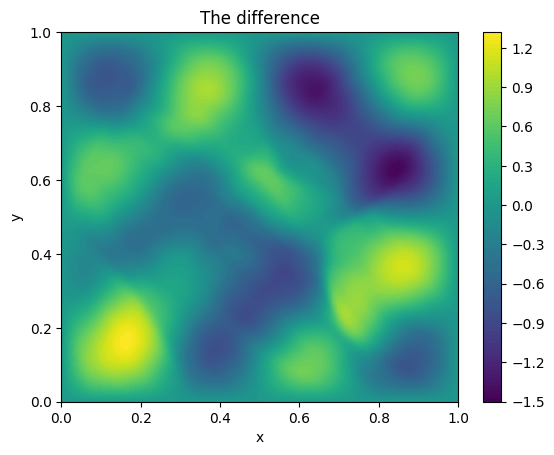

In [ ]:
model.compile("adam", lr=1e-4)
losshistory, train_state = model.train(iterations=100000)

x = np.linspace(0,1,100)
y = np.linspace(0,1,100)
X, Y = np.meshgrid(x,y)
z = np.hstack((X.reshape(10000,1), Y.reshape(10000,1)))
u_pred = model.predict(z).reshape(100,100)
u_true = Helm_solution(z).reshape(100,100)

plt.contourf(X, Y, u_true - u_pred, levels=100)
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.title("The difference")
plt.show()

Now let us plot the snapshots of solutions.

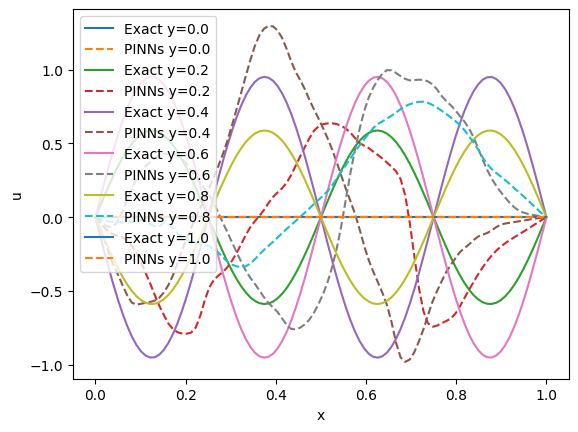

In [ ]:
x = np.linspace(0, 1, 100)
for i in range(0, 6):
    y = [i/5]*100
    X = np.stack([x, y], 1)
    u_pred = model.predict(X)
    plt.plot(x, Helm_solution(X), label='Exact y={}'.format(i/5))
    plt.plot(x, u_pred.flatten(), '--', label='PINNs y={}'.format(i/5))
plt.xlabel('x')
plt.ylabel('u')
plt.legend()
plt.show()

Now let us train the same model with `sin` as the activation function, with all other parameters being the same

In [ ]:
net = dde.nn.FNN(
    [2] + [150] * 3 + [1], "sin", "Glorot uniform"
)
net.apply_output_transform(transform)
model = dde.Model(data, net)

Compiling model...
Building feed-forward neural network...
'build' took 0.062487 s

'compile' took 2.010311 s

Training model...

Step      Train loss    Test loss     Test metric
0         [4.97e+03]    [4.97e+03]    []  
1000      [4.97e+03]    [4.97e+03]    []  
2000      [3.27e+03]    [3.27e+03]    []  
3000      [2.75e+02]    [2.75e+02]    []  
4000      [1.39e+02]    [1.39e+02]    []  
5000      [1.11e+02]    [1.11e+02]    []  
6000      [8.09e+01]    [8.09e+01]    []  
7000      [1.11e+01]    [1.11e+01]    []  
8000      [1.09e+00]    [1.09e+00]    []  
9000      [2.66e-01]    [2.66e-01]    []  
10000     [1.22e-01]    [1.22e-01]    []  
11000     [8.32e-02]    [8.32e-02]    []  
12000     [4.38e-02]    [4.38e-02]    []  
13000     [4.63e-02]    [4.63e-02]    []  
14000     [2.09e-02]    [2.09e-02]    []  
15000     [7.71e-02]    [7.71e-02]    []  
16000     [1.40e-02]    [1.40e-02]    []  
17000     [1.15e-02]    [1.15e-02]    []  
18000     [1.78e-02]    [1.78e-02]    []  
190

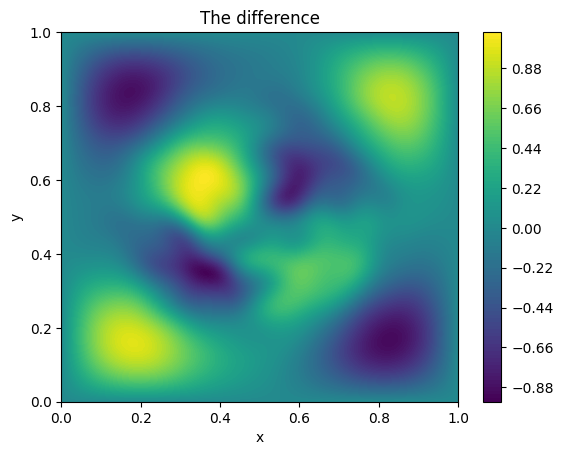

In [ ]:
model.compile("adam", lr=1e-4)
# checker = dde.callbacks.ModelCheckpoint("model.ckpt", save_better_only=True, period=1000)
# losshistory, train_state = model.train(iterations=5000, callbacks=[checker])
losshistory, train_state = model.train(iterations=30000)

x = np.linspace(0,1,100)
y = np.linspace(0,1,100)
X, Y = np.meshgrid(x,y)
z = np.hstack((X.reshape(10000,1), Y.reshape(10000,1)))
u_pred = model.predict(z).reshape(100,100)
u_true = Helm_solution(z).reshape(100,100)
plt.contourf(X, Y, u_true - u_pred, levels=100)
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.title("The difference")
plt.show()

Let's plot the function $x\mapsto u(x,y)$ for some fixed values of $y$ and compare to the prediction.

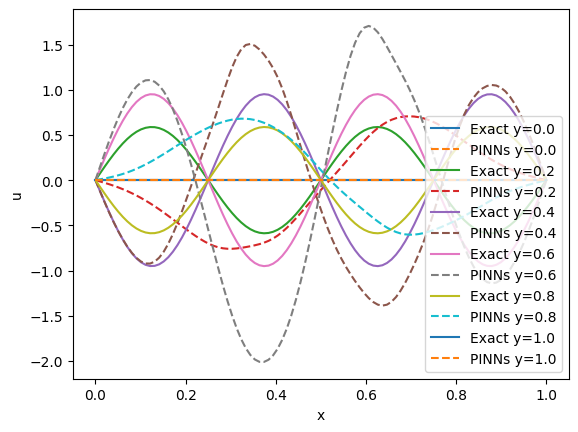

In [ ]:
x = np.linspace(0, 1, 100)
for i in range(0, 6):
    y = [i/5]*100
    X = np.stack([x, y], 1)
    u_pred = model.predict(X)
    plt.plot(x, Helm_solution(X), label='Exact y={}'.format(i/5))
    plt.plot(x, u_pred.flatten(), '--', label='PINNs y={}'.format(i/5))
plt.xlabel('x')
plt.ylabel('u')
plt.legend()
plt.show()

We see that the convergence of the model is somewhat different with `sin` as an activation function compared with the `tanh` activation function. One thing that is different is that the system with `sin` can tolerate larger learning rates: in fact, it will comverge with the learning rate as large as 1e-3, for example. In reality, the choice of activation functions is a highly non-trivial quesiton.

### the number of training points
In this subsection we investigate the impact of the number of interior and boundary points on the performance of the model.

In [ ]:
def Helm_pde(z, u):
    # z = (x, y)
    du_xx = dde.grad.hessian(u, z, i=0, j=0)
    du_yy = dde.grad.hessian(u, z, i=1, j=1)

    f = kappa ** 2 * tf.sin(kappa * z[:, 0:1]) * tf.sin(kappa * z[:, 1:2])
    return du_xx + du_yy + kappa ** 2 * u + f

def boundary(_, on_boundary):
    return on_boundary

geom = dde.geometry.Rectangle([0, 0], [1, 1])
bc = dde.icbc.DirichletBC(geom, lambda z: 0, boundary)

def transform(z, u):
    res = z[:, 0:1] * (1 - z[:, 0:1]) * z[:, 1:2] * (1 - z[:, 1:2])
    return res * u

net = dde.nn.FNN(
    [2] + [150] * 3 + [1], "sin", "Glorot uniform"
)

net.apply_output_transform(transform)

In [ ]:
#This step takes very long time to cycle through all the boundary points! We will not execute it during the class
x = np.linspace(0,1,100)
y = np.linspace(0,1,100)
X, Y = np.meshgrid(x,y)
error = []
boundary_list = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
for num_boundary in boundary_list:
    data = dde.data.PDE(
        geom,
        Helm_pde,
        [],
        num_domain=100,
        num_boundary=num_boundary,
    )

    model = dde.Model(data, net)
    model.compile("adam", lr=1e-4)
    losshistory, train_state = model.train(iterations=10000)
    z = np.hstack((X.reshape(10000,1), Y.reshape(10000,1)))
    u_pred = model.predict(z).reshape(100,100)
    u_true = Helm_solution(z).reshape(100,100)
    error.append(np.mean((u_pred - u_true)**2))

Compiling model...
Building feed-forward neural network...
'build' took 0.046563 s

'compile' took 1.166068 s

Training model...

Step      Train loss    Test loss     Test metric
0         [5.97e+03]    [5.97e+03]    []  
1000      [3.94e+03]    [3.94e+03]    []  
2000      [1.07e+03]    [1.07e+03]    []  
3000      [1.34e+02]    [1.34e+02]    []  
4000      [1.53e+01]    [1.53e+01]    []  
5000      [1.14e-01]    [1.14e-01]    []  
6000      [5.22e-05]    [5.22e-05]    []  
7000      [7.54e-05]    [7.54e-05]    []  
8000      [1.13e-03]    [1.13e-03]    []  
9000      [5.35e-03]    [5.35e-03]    []  
10000     [8.30e-03]    [8.30e-03]    []  

Best model at step 6000:
  train loss: 5.22e-05
  test loss: 5.22e-05
  test metric: []

'train' took 64.940613 s

Compiling model...
'compile' took 0.835568 s

Training model...

Step      Train loss    Test loss     Test metric
0         [5.70e+03]    [5.70e+03]    []  
1000      [3.55e+03]    [3.55e+03]    []  
2000      [4.54e+02]    [4.54e

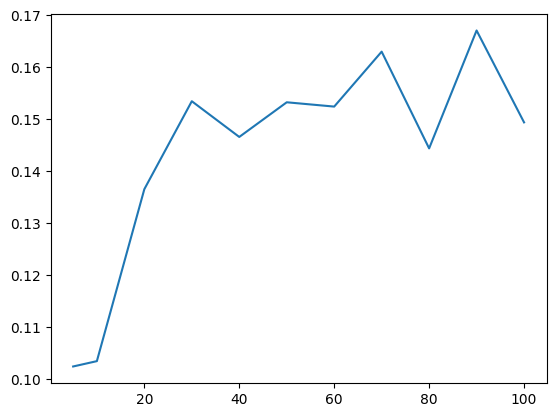

In [ ]:
plt.plot(boundary_list, error)
plt.show()

### Question

Plot the resulting PDE equation residual (the loss that was used in the training) at every point in the domain.

In [ ]:
#@title answer

x = np.linspace(0,1,100)
y = np.linspace(0,1,100)

X, Y = np.meshgrid(x, y)
z = np.hstack((X.reshape(10000,1), Y.reshape(10000,1)))

pde_loss = model.predict(z, operator=Helm_pde).reshape(100,100)

plt.contourf(X, Y, pde_loss, levels=100)
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.title("The difference")
plt.show()

## The transport equation

Consider the $1$-dimensional transport equation
$$ u_t + c u_x = 0, \qquad  (x, t)\in [- \infty,\infty]\times [0, 1] $$
with initial condition
$$u(x, 0) = g(x).$$
The exact solution is $u(x, t) = g(x- tc)$.

We take $x \in [-L,L]$ where $L$ is sufficiently large not to feel the effect of the boundaries. As it turns out, some boundary conditions may pose difficulties for PINNs.

In [ ]:
c = 1.
L = 4.

def g_func(x):
    return np.sin(pi*x)

def transport_sol(x):
    return g_func(x[:,0:1] - x[:,1:2]*c)

In [ ]:
def transport_pde(z, u):
    du_x = dde.grad.jacobian(u, z, i=0, j=0)
    du_t = dde.grad.jacobian(u, z, i=0, j=1)

    return du_t + c * du_x

def boundary(_, on_boundary):
    return on_boundary

geom = dde.geometry.Interval(-L, L)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

ic = dde.icbc.IC(
    geomtime,
    lambda z: g_func(z[:,0:1]),
    boundary,
)
data = dde.data.TimePDE(
    geomtime,
    transport_pde,
    [ic],
    num_domain=400,
    num_boundary=21,
    num_initial=16,
)
net = dde.nn.FNN(
    [2] + [64] * 3 + [1], "sin", "Glorot uniform"
)
model = dde.Model(data, net)

Compiling model...
Building feed-forward neural network...
'build' took 0.077213 s

'compile' took 1.656490 s

Training model...

Step      Train loss              Test loss               Test metric
0         [6.26e-03, 4.96e-01]    [6.26e-03, 4.96e-01]    []  
1000      [2.05e-04, 4.94e-04]    [2.05e-04, 4.94e-04]    []  
2000      [7.60e-05, 1.00e-04]    [7.60e-05, 1.00e-04]    []  
3000      [2.25e-05, 1.81e-05]    [2.25e-05, 1.81e-05]    []  
4000      [1.23e-05, 6.16e-05]    [1.23e-05, 6.16e-05]    []  
5000      [5.21e-06, 2.19e-06]    [5.21e-06, 2.19e-06]    []  

Best model at step 5000:
  train loss: 7.40e-06
  test loss: 7.40e-06
  test metric: []

'train' took 43.748316 s



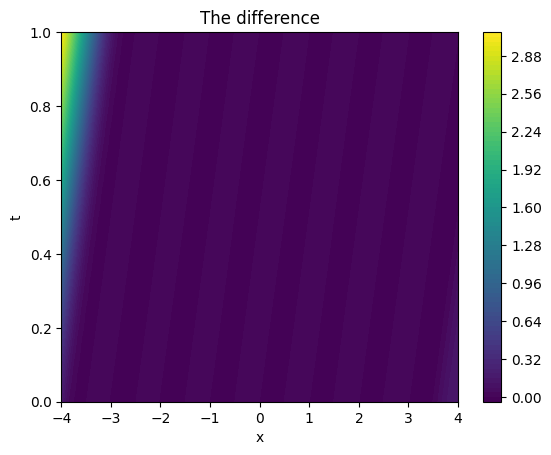

In [ ]:
model.compile("adam", lr=1e-3)
losshistory, train_state = model.train(iterations=5000)

x = np.linspace(-L,L,100)
t = np.linspace(0,1,100)
X, T = np.meshgrid(x,t)
z = np.hstack((X.reshape(10000,1), T.reshape(10000,1)))

u_pred = model.predict(z).reshape(100,100)
u_true = transport_sol(z).reshape(100,100)

plt.contourf(X, T, u_true - u_pred, levels=100)
plt.colorbar()
plt.xlabel("x")
plt.ylabel("t")
plt.title("The difference")
plt.show()

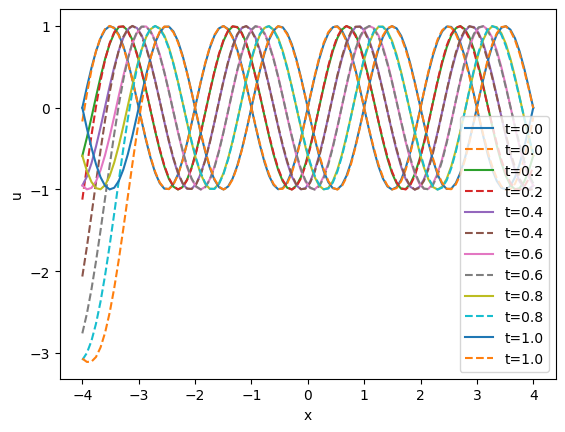

In [ ]:
x = np.linspace(-L, L, 100)
for i in range(0, 6):
    t = [i/5]*100
    X = np.stack([x, t], 1)
    u_pred = model.predict(X)
    plt.plot(x, transport_sol(X), label='t={}'.format(i/5))
    plt.plot(x, u_pred.flatten(), '--', label='t={}'.format(i/5))
plt.xlabel('x')
plt.ylabel('u')
plt.legend()
plt.show()

### Question

Change the equation parameter $c$ and initial condition function $g(x)$ to see their influence.

## The wave equation

Consider the equation

$$u_{tt} - u_{xx} = 0,\quad (x,t)\in [0,L]\times [0,1],$$
$$ u(0,t)= u(L,t)=0,\quad t\in [0,1],$$
$$u(x, 0)=\sin\left(\frac{\pi}{L}x\right)\quad \text{and}\quad u_t(x, 0) = 0, \quad x\in [0,L].$$

The exact solution is
$$
u(x,t) =\sin\left(\frac{\pi}{L}x\right)\cos\left(\frac{\pi}{L}t\right).
$$


In [ ]:
L = 8

In [ ]:
def u0_func(x):
    return tf.sin(pi * x / L)

def u1_func(x):
    return tf.zeros_like(x)

def wave_solution(z):
    return  np.sin(pi * z[:,0:1] / L)*np.cos(pi * z[:,1:2] / L)

In [ ]:
def wave_pde(z, u):
    # z=(x, t)
    u_xx = dde.grad.hessian(u, z, i=0, j=0)
    u_tt = dde.grad.hessian(u, z, i=1, j=1)
    return u_tt - u_xx

geom = dde.geometry.Interval(0, L)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

def boundary(_, on_initial):
    return on_initial

ic1 = dde.icbc.IC(geomtime, lambda z: u0_func(z[:,0:1]), boundary)

ic2 = dde.icbc.OperatorBC(
    geomtime,
    lambda z, u, _: dde.grad.jacobian(u, z, j=1) - u1_func(z[:,0:1]),
    boundary,
    )

data = dde.data.TimePDE(
    geomtime, wave_pde, ic_bcs=[ic1, ic2],
    num_domain=40, num_boundary=8, num_initial=16,
)

net = dde.nn.FNN([2] + [64] * 4 + [1], "tanh", "Glorot normal")
model = dde.Model(data, net)

In [ ]:
model.compile("adam", lr=1e-4)
losshistory, train_state = model.train(iterations=10000)

Compiling model...
Building feed-forward neural network...
'build' took 0.088523 s

'compile' took 2.496300 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.35e-03, 7.38e-02, 6.21e-03]    [1.35e-03, 7.38e-02, 6.21e-03]    []  
1000      [2.71e-05, 1.88e-05, 8.33e-07]    [2.71e-05, 1.88e-05, 8.33e-07]    []  
2000      [1.02e-05, 9.24e-06, 7.51e-07]    [1.02e-05, 9.24e-06, 7.51e-07]    []  
3000      [7.33e-06, 1.66e-06, 5.30e-07]    [7.33e-06, 1.66e-06, 5.30e-07]    []  
4000      [5.23e-06, 2.58e-05, 4.28e-07]    [5.23e-06, 2.58e-05, 4.28e-07]    []  
5000      [3.73e-06, 1.38e-07, 1.60e-07]    [3.73e-06, 1.38e-07, 1.60e-07]    []  
6000      [2.69e-06, 1.31e-07, 9.03e-08]    [2.69e-06, 1.31e-07, 9.03e-08]    []  
7000      [1.97e-06, 1.32e-07, 5.54e-08]    [1.97e-06, 1.32e-07, 5.54e-08]    []  
8000      [1.48e-06, 1.30e-07, 3.83e-08]    [1.48e-06, 1.30e-07, 3.83e-08]    []  
9000      [1.13e-06, 1.25e-07, 2.

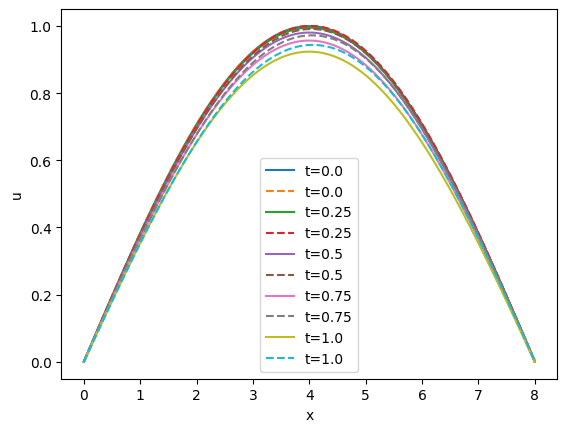

In [ ]:
x = np.linspace(0, L, 100)
for i in range(5):
    t = [i/4]*100
    X = np.stack([x, t], 1)
    u_pred = model.predict(X)
    plt.plot(x, wave_solution(X), label='t={}'.format(i/4))
    plt.plot(x, u_pred.flatten(), '--', label='t={}'.format(i/4))
plt.xlabel('x')
plt.ylabel('u')
plt.legend()
plt.show()

### Question

Try to minimize neural-network parameters (number of layers and neurons) to find "the most" compact network still providing an acceptable accuracy.

Modify this line of code above:
```python
net = dde.nn.FNN([2] + [64] * 4 + [1], "tanh", "Glorot normal")
```

## Eikonal equation

The **Eikonal equation** in geometric optics is a differential equation of the form
$$
\left|\nabla u(x)\right| = \frac{1}{c(x)},\tag{13}$$
for $x\in \Omega = [0,L]^2$, and $c$, a positive function, called the **speed function**. Suppose that the speed is constant $c=1$.

The theoretical solution is the signed distance function
$$
f(x) = d(x,\partial \Omega)
.$$

In [ ]:
L = 2
def sdf(x,y):
  u = np.stack([x, y, L-x, L-y], 1)
  return np.min(u, axis=1)

In [ ]:
def Eikonal_deepxde(x, y):
    dy_x = dde.grad.jacobian(y, x, i=0, j=0)
    dy_y = dde.grad.jacobian(y, x, i=0, j=1)
    return dy_x**2 + dy_y**2 - 1

def boundary(_, on_boundary):
    return on_boundary

geom = dde.geometry.Rectangle([0, 0], [L, L])

bc = dde.icbc.DirichletBC(geom, lambda x: 0, boundary)

data = dde.data.PDE(
    geom,
    Eikonal_deepxde,
    bc,
    num_domain=500,
    num_boundary=100,
)

def output_transform(t, u):
    return tf.math.abs(u)

net = dde.nn.FNN(
    [2] + [40] * 3 + [1], 'tanh', "Glorot normal"
)
net.apply_output_transform(output_transform)

model = dde.Model(data, net)
model.compile("adam", lr=1e-4, loss='mse')

losshistory, train_state = model.train(iterations=20000, display_every=2500)

Compiling model...
Building feed-forward neural network...
'build' took 0.054556 s

'compile' took 0.450655 s

Training model...

Step      Train loss              Test loss               Test metric
0         [8.91e-01, 3.64e-02]    [8.91e-01, 3.64e-02]    []  
2500      [2.96e-02, 1.51e-02]    [2.96e-02, 1.51e-02]    []  
5000      [7.26e-03, 7.89e-03]    [7.26e-03, 7.89e-03]    []  
7500      [3.65e-03, 3.85e-03]    [3.65e-03, 3.85e-03]    []  
10000     [1.63e-03, 7.41e-04]    [1.63e-03, 7.41e-04]    []  
12500     [1.19e-03, 3.91e-04]    [1.19e-03, 3.91e-04]    []  
15000     [9.43e-04, 2.51e-04]    [9.43e-04, 2.51e-04]    []  
17500     [6.33e-04, 1.56e-04]    [6.33e-04, 1.56e-04]    []  
20000     [3.93e-04, 1.10e-04]    [3.93e-04, 1.10e-04]    []  

Best model at step 20000:
  train loss: 5.03e-04
  test loss: 5.03e-04
  test metric: []

'train' took 25.660032 s



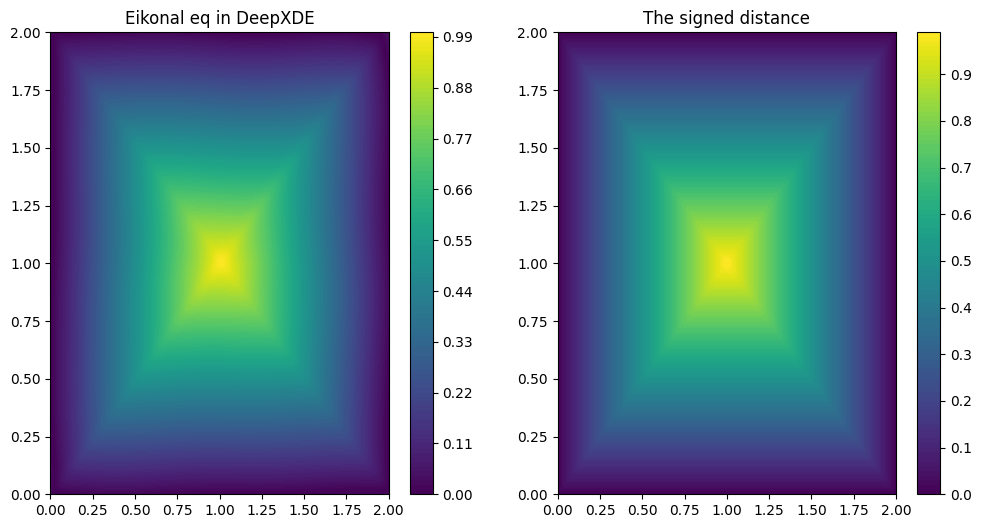

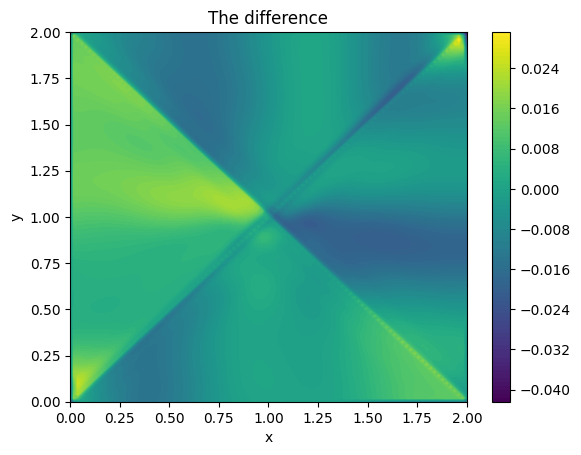

In [ ]:
x = np.linspace(0,L,100)
y = np.linspace(0,L,100)
X, Y = np.meshgrid(x,y)
Z_pred = model.predict(np.stack([X.flatten(), Y.flatten()], 1)).reshape(100, 100)
Z_true = sdf(X, Y)

#the plots
fig, axs = plt.subplots(1, 2,figsize=(12, 6))
plt.colorbar(axs[0].contourf(X, Y, Z_pred.reshape(100,100), levels=100))
plt.colorbar(axs[1].contourf(X, Y, Z_true, levels=100))
axs[0].set_title("Eikonal eq in DeepXDE")
axs[1].set_title("The signed distance")
plt.show()

# the difference
plt.contourf(X, Y, Z_true - Z_pred.reshape(100,100), levels=100)
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.title("The difference")
plt.show()

### Question

Try increasing/decreasing number of points in the domain and on the boundary. How does it affect the convergence/accuracy?

## Effect of the distribution of the number of points on accuracy

Keeping with the Eikonal equation, we explore how the ratio of domain points to the number of boundary points could affect the accuracy of the model.

In [ ]:
domain = [400, 500, 600]
boundary = [50, 100, 200]

x = np.linspace(0,L,100)
y = np.linspace(0,L,100)
X, Y = np.meshgrid(x,y)
Z_true = sdf(X, Y)

output = {}
for num_domain in domain:
    for num_boundary in boundary:
        data = dde.data.PDE(
        geom,
        Eikonal_deepxde,
        bc,
        num_domain=num_domain,
        num_boundary=num_boundary,
        )

        model = dde.Model(data, net)
        model.compile("adam", lr=1e-4)
        losshistory, train_state = model.train(iterations=20000)
        output['{}_{}'.format(num_domain, num_boundary)] = model.predict(np.stack([X.flatten(), Y.flatten()], 1)).reshape(100, 100)

Compiling model...
'compile' took 0.396925 s

Training model...

Step      Train loss              Test loss               Test metric
0         [9.91e-01, 5.24e-03]    [9.91e-01, 5.24e-03]    []  
1000      [1.04e-01, 4.24e-01]    [1.04e-01, 4.24e-01]    []  
2000      [6.43e-02, 1.26e-02]    [6.43e-02, 1.26e-02]    []  
3000      [2.78e-02, 1.14e-02]    [2.78e-02, 1.14e-02]    []  
4000      [1.25e-02, 7.65e-03]    [1.25e-02, 7.65e-03]    []  
5000      [6.50e-03, 5.59e-03]    [6.50e-03, 5.59e-03]    []  
6000      [4.25e-03, 4.85e-03]    [4.25e-03, 4.85e-03]    []  
7000      [3.34e-03, 3.99e-03]    [3.34e-03, 3.99e-03]    []  
8000      [2.81e-03, 3.17e-03]    [2.81e-03, 3.17e-03]    []  
9000      [2.63e-03, 2.50e-03]    [2.63e-03, 2.50e-03]    []  
10000     [2.40e-03, 1.80e-03]    [2.40e-03, 1.80e-03]    []  
11000     [2.00e-03, 1.37e-03]    [2.00e-03, 1.37e-03]    []  
12000     [1.64e-03, 1.06e-03]    [1.64e-03, 1.06e-03]    []  
13000     [1.31e-03, 8.35e-04]    [1.31e-03, 8

In what follows the plots of the errors as a function of the number of points. The number of points is represented as a couple $(i,j)$ where $i$ and $ j$, respectively, represent the number of domain and boundary points.

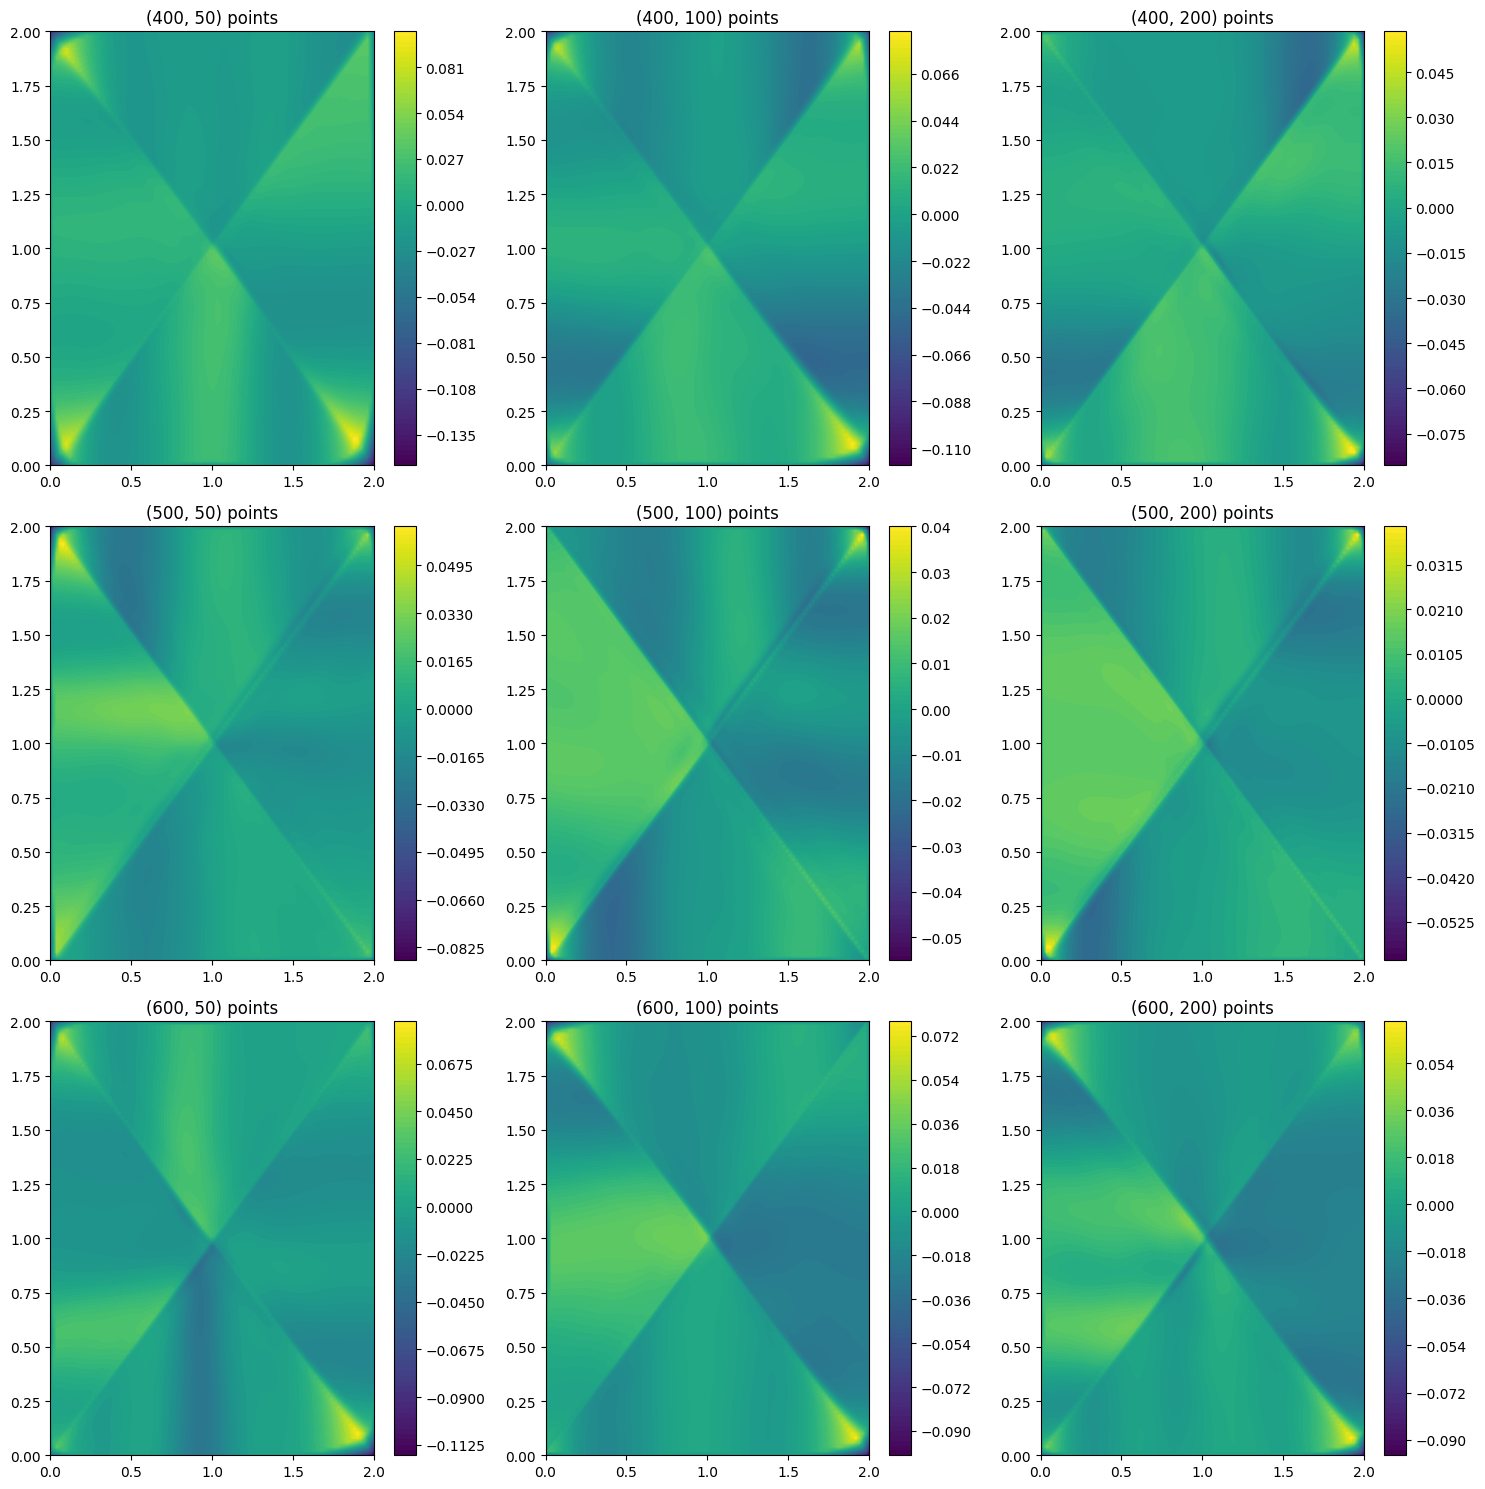

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

for i in range(3):
  for j in range(3):
    plt.colorbar(axs[i, j].contourf(X, Y, Z_true - output['{}_{}'.format(domain[i], boundary[j])], levels=100))
    axs[i, j].set_title('({}, {}) points'.format(domain[i], boundary[j]))

plt.tight_layout()

plt.show()

The first obvious remark we get from these plots is that going from left to right, the accuracy improves. In other words increasing the numbre of boundary points led to better results.

Looking at the two bottom rows in the plots, we notice something interesting. We see that the configurations $(500, 50), (500, 100) $ and $(500, 200)$, respectively, give better results thant the configurations $(600, 50), (600, 100) $ and $(600, 200)$.

## Inviscid Burgers' equation

The equation $$
u_t + uu_x = 0 $$
with the initial condition $$u\left(x,0\right) = ax+b $$

is called the inviscid Burgers' equation with linear initial condition. Its exact solution is $$u(x,t)=\frac{ax+b}{at +1}.$$

In [ ]:
a = 2.
b = 3.

In [ ]:
def inviscid_sol(z):
    return (a*z[:,0:1] + b) / (a*z[:,1:2] + 1)

In [ ]:
L = 2 # the lenght of the interval
def inviscid_burgers(z, u):
    # z = (x, t)
    u_x = dde.grad.jacobian(u, z, j=0)
    u_t = dde.grad.jacobian(u, z, j=1)
    return u_t + u * u_x

geom = dde.geometry.Interval(0, L)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

def boundary(_, on_initial):
    return on_initial

def inviscid_burgers0(x):
    return a*x + b

ic = dde.icbc.IC(geomtime, lambda x: inviscid_burgers0(x[:,0:1]), boundary)

data = dde.data.TimePDE(
    geomtime, inviscid_burgers, ic_bcs=[ic],
    num_domain=40, num_boundary=8, num_initial=16,
)
net = dde.nn.FNN([2] + [32] * 4 + [1], "tanh", "Glorot normal")
model = dde.Model(data, net)

In [ ]:
model.compile("adam", lr=1e-4)
losshistory, train_state = model.train(iterations=20000)

Compiling model...
Building feed-forward neural network...
'build' took 0.116361 s

'compile' took 2.490700 s

Training model...

Step      Train loss              Test loss               Test metric
0         [6.95e-02, 2.44e+01]    [6.95e-02, 2.44e+01]    []  
1000      [8.00e-02, 5.60e-01]    [8.00e-02, 5.60e-01]    []  
2000      [1.55e-02, 5.79e-02]    [1.55e-02, 5.79e-02]    []  
3000      [1.87e-03, 1.76e-02]    [1.87e-03, 1.76e-02]    []  
4000      [1.24e-03, 9.71e-03]    [1.24e-03, 9.71e-03]    []  
5000      [1.18e-03, 3.81e-03]    [1.18e-03, 3.81e-03]    []  
6000      [7.33e-04, 9.85e-04]    [7.33e-04, 9.85e-04]    []  
7000      [2.84e-04, 1.96e-04]    [2.84e-04, 1.96e-04]    []  
8000      [9.47e-05, 4.52e-05]    [9.47e-05, 4.52e-05]    []  
9000      [3.93e-05, 1.89e-05]    [3.93e-05, 1.89e-05]    []  
10000     [2.50e-05, 1.16e-05]    [2.50e-05, 1.16e-05]    []  
11000     [2.08e-05, 8.02e-06]    [2.08e-05, 8.02e-06]    []  
12000     [1.14e-05, 4.90e-06]    [1.14e-05,

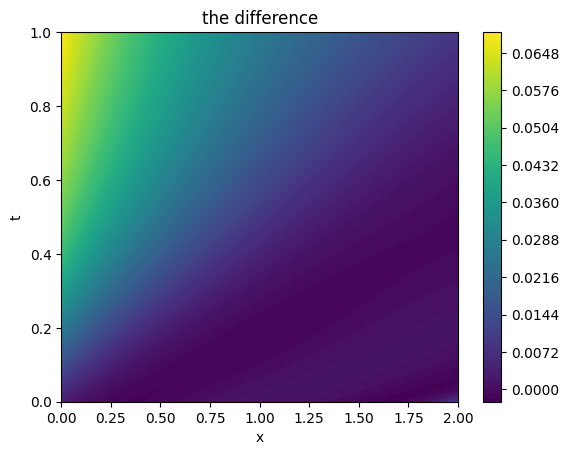

In [ ]:
t = np.linspace(0, 1, 100)
x = np.linspace(0, L, 100)
X, T = np.meshgrid(x,t)
Z_pred = model.predict(np.hstack((X.reshape(10000,1), T.reshape(10000,1))))
Z_true = (a*X + b) / (a*T + 1)
plt.contourf(X, T, Z_true - Z_pred.reshape(100,100), levels=100)
plt.title("the difference")
plt.xlabel("x")
plt.ylabel("t")
plt.colorbar()
plt.show()

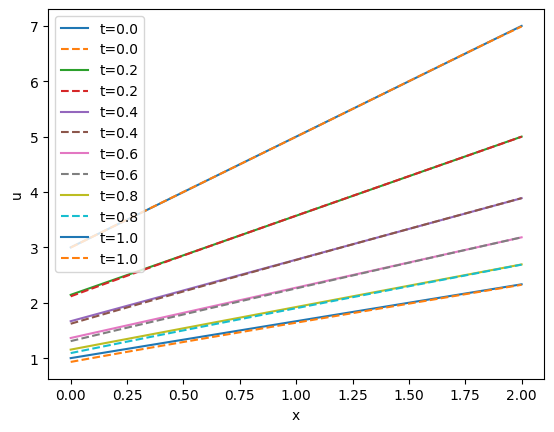

In [ ]:
x = np.linspace(0, L, 100)
for i in range(0, 6):
    t = [i/5]*100
    X = np.stack([x, t], 1)
    u_pred = model.predict(X)
    plt.plot(x, inviscid_sol(X), label='t={}'.format(i/5))
    plt.plot(x, u_pred.flatten(), '--', label='t={}'.format(i/5))
plt.xlabel('x')
plt.ylabel('u')
plt.legend()
plt.show()

### Question

Change the parameters $a$ and $b$, to see how that may affect the PINN convergence.

## Viscous Burgers' equation

Consider the equation $$u_t + uu_x = \nu u_{xx},$$
$$ u(x,0) = F(x).$$

For $t>0$, define $$
f\left( x,y,t\right) =\frac{1}{2\nu }\int_{0}^{y}F\left( s\right) \mathrm{d}s+\frac{
\left( x-y\right) ^{2}}{2t}.$$

The exact solution is
$$u\left( x,t\right) = \dfrac{\int_{-\infty }^{\infty }\left( \frac{x-y}{t}\right) \exp \left[ -
\dfrac{f(x,y,t)}{2\nu }\right] \mathrm{d}y}{\int_{-\infty }^{\infty }\exp \left[ -\frac{f(x,y,t)}{
2\nu }\right] \mathrm{d}y}, \quad t\neq 0.
$$

In [ ]:
nu = 0.01
L = 1 # half the length of the interval

In [ ]:
def u0_func(x):
   return np.sin(pi*x)

In [ ]:
def f_func(x, y, t):
    A = ((x - y)**2) / t
    B = quad(u0_func, 0, y)[0]
    return (A + B) / (2*nu)

In [ ]:
def u_den(x, t):
    def u_den_exp(y):
        return np.exp(-f_func(x, y, t) / 2*nu)
    return quad(u_den_exp, -np.inf, np.inf)[0]

In [ ]:
def u_num(x, t):
    def u_num_exp(y):
        return np.exp(-f_func(x, y, t) / 2*nu) * (x - y)/t
    return quad(u_num_exp, -np.inf, np.inf)[0]

In [ ]:
def u_solution(x, t):
  return u_num(x, t) / u_den(x, t)

In [ ]:
u_solution(np.pi, 0.5)

<ipython-input-38-26e66405cb94>:3: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  B = quad(u0_func, 0, y)[0]


-1.8214889595173873e-15

In [ ]:
def burgers_pde(z, u):
    du_x = dde.grad.jacobian(u, z, i=0, j=0)
    du_t = dde.grad.jacobian(u, z, i=0, j=1)
    du_xx = dde.grad.hessian(u, z, i=0, j=0)
    return du_t + u * du_x - nu * du_xx

geom = dde.geometry.Interval(-L, L)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)
ic = dde.icbc.IC(
    geomtime, lambda z: u0_func(z[:, 0:1]), lambda _, on_initial: on_initial
)

data = dde.data.TimePDE(
    geomtime, burgers_pde, [ic, bc], num_domain=2540, num_boundary=80, num_initial=160
)
net = dde.nn.FNN([2] + [20] * 3 + [1], "tanh", "Glorot normal")
model = dde.Model(data, net)

model.compile("adam", lr=1e-3)
model.train(iterations=15000)
model.compile("L-BFGS")
losshistory, train_state = model.train()

Compiling model...
Building feed-forward neural network...
'build' took 0.246584 s

'compile' took 5.855063 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [2.34e-03, 3.33e-01, 6.35e-02]    [2.34e-03, 3.33e-01, 6.35e-02]    []  
1000      [5.28e-03, 1.87e-03, 2.34e-03]    [5.28e-03, 1.87e-03, 2.34e-03]    []  
2000      [6.82e-04, 6.09e-05, 2.11e-04]    [6.82e-04, 6.09e-05, 2.11e-04]    []  
3000      [2.43e-04, 1.08e-05, 1.49e-05]    [2.43e-04, 1.08e-05, 1.49e-05]    []  
4000      [1.64e-04, 1.68e-05, 2.66e-05]    [1.64e-04, 1.68e-05, 2.66e-05]    []  
5000      [1.11e-04, 9.62e-06, 4.56e-06]    [1.11e-04, 9.62e-06, 4.56e-06]    []  
6000      [8.83e-05, 8.65e-06, 3.57e-06]    [8.83e-05, 8.65e-06, 3.57e-06]    []  
7000      [7.58e-05, 8.10e-06, 4.05e-06]    [7.58e-05, 8.10e-06, 4.05e-06]    []  
8000      [6.76e-05, 7.69e-06, 4.68e-06]    [6.76e-05, 7.69e-06, 4.68e-06]    []  
9000      [5.70e-05, 5.68e-06, 2.

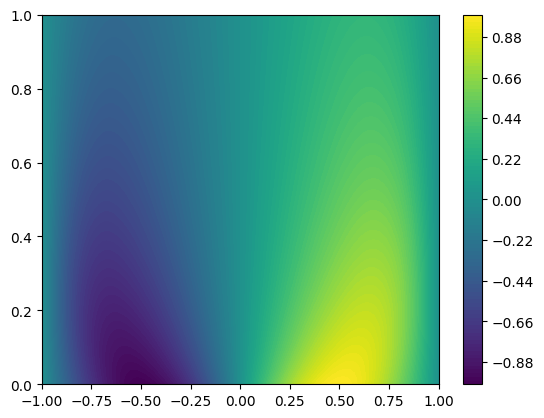

In [ ]:
x = np.linspace(-L,L,100)
t = np.linspace(0,1,100)
X, T = np.meshgrid(x, t)
X_flat = X.reshape(10000,1)
T_flat = T.reshape(10000,1)
u_pred = model.predict(np.hstack((X_flat,T_flat)))
plt.contourf(X, T, u_pred.reshape(100,100), levels=100)
plt.colorbar()
plt.show()

## The KDV equation

Consider the KDV equation $$
u_{t}+u_{xxx}-6uu_x =0
$$
Consider a solution of the form $u(x,t)=f(x-ct-a)$ for some $f$. If furthermore we assume that $f(X)\to 0$ as $X\to -\infty$, then there is a unique such solution and is given by
$$
u(x, t) =-\frac{1}{2}c\,\mathrm{sech}^{2}\left[ \frac{\sqrt{c}}{2}\left(
x-ct-a\right) \right].
$$


The constants of the problem:

In [ ]:
L = 4 # half the length of the interval
c = 1
d = np.sqrt(c)
a = 1

In [ ]:
def sech(x):
    return 1/np.cosh(x)

Define the solution:

In [ ]:
def KDV_solution(X):
    return -c*sech(d * (X[:,0:1] - c * X[:,1:2] - a) / 2)**2 / 2

Write the DeepXDE code:

In [ ]:
def KDV_pde(z, u):
    # z=(x, t)
    u_xx = dde.grad.hessian(u, z, i=0, j=0)
    u_xxx = dde.grad.jacobian(u_xx, z, i=0, j=0)
    u_t = dde.grad.jacobian(u, z, i=0, j=1)
    u_x = dde.grad.jacobian(u, z, i=0, j=0)
    return u_t + u_xxx - 6 * u * u_x

geom = dde.geometry.Interval(-L, L)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

def boundary(_, on_initial):
    return on_initial

def KDV0_func(x):
    return -c*sech(d*(x - a) / 2)**2 / 2

ic = dde.icbc.IC(
    geomtime, lambda x: KDV0_func(x[:, 0:1]), boundary,
)

data = dde.data.TimePDE(
    geomtime, KDV_pde, ic_bcs=[ic],
    num_domain=40, num_boundary=8, num_initial=16,
)
net = dde.nn.FNN([2] + [32] * 4 + [1], "tanh", "Glorot normal")
model = dde.Model(data, net)

In [ ]:
model.compile("adam", lr=1e-4)
losshistory, train_state = model.train(iterations=4000)

Compiling model...
Building feed-forward neural network...
'build' took 0.081887 s

'compile' took 2.807112 s

Training model...

Step      Train loss              Test loss               Test metric
0         [7.54e-02, 1.39e-01]    [7.54e-02, 1.39e-01]    []  
1000      [1.23e-03, 1.94e-03]    [1.23e-03, 1.94e-03]    []  
2000      [3.80e-04, 1.50e-04]    [3.80e-04, 1.50e-04]    []  
3000      [8.51e-05, 8.10e-06]    [8.51e-05, 8.10e-06]    []  
4000      [3.04e-05, 3.66e-06]    [3.04e-05, 3.66e-06]    []  

Best model at step 4000:
  train loss: 3.40e-05
  test loss: 3.40e-05
  test metric: []

'train' took 22.651731 s



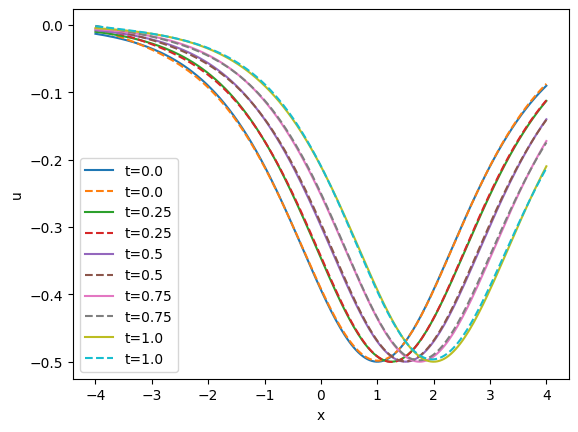

In [ ]:
x = np.linspace(-L, L, 200)
for i in range(0, 13, 3):
    t = [i/12]*200
    X = np.stack([x, t], 1)
    u_pred = model.predict(X)
    plt.plot(x, KDV_solution(X), label='t={}'.format(i/12))
    plt.plot(x, u_pred.flatten(), '--', label='t={}'.format(i/12))
plt.xlabel('x')
plt.ylabel('u')
plt.legend()
plt.show()

### Question

Change the parameters $a$ and $c$ which affects the boundary conditions, to see how that may affect the PINN convergence.

## Camassa-Holm equation

Consider **Camassa-Holm** equation $$
u_t - u_{xxt} + 3uu_{x} -2 u_xu_{xx} - uu_{xxx} = 0,
$$
with initial condition
$$
u(x,0)= ce^{-|x|},
$$
where $c$ is a constant.

In [ ]:
c = 2
L = 4 # half the length of the interval

In [ ]:
def pde(X, u):
    x, t = X[:,0:1], X[:,1:2]
    u_t = dde.grad.jacobian(u, X, i=0, j=1)
    u_x = dde.grad.jacobian(u, X, i=0, j=0)
    u_xx = dde.grad.hessian(u, X, i=0, j=0)
    u_xxx = dde.grad.jacobian(u_xx, X, i=0, j=0)
    u_xxt = dde.grad.jacobian(u_xx, X, i=0, j=1)
    return u_t - u_xxt + 3*u*u_x - 2*u_x*u_xx - u*u_xxx

geom = dde.geometry.Interval(-L, L)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

def u0(x):
    return c*tf.exp(-tf.abs(x))

ic = dde.icbc.IC(
    geomtime, lambda x: u0(x[:,0:1]), lambda _, on_initial: on_initial,
)

data = dde.data.TimePDE(
    geomtime, pde, [ic], num_domain=64, num_boundary=64, num_initial=160
)

net = dde.nn.FNN([2] + [24] * 6 + [1], "tanh", "Glorot normal")
model = dde.Model(data, net)

In [ ]:
model.compile("adam", lr=1e-4)
losshistory, train_state = model.train(iterations=20000)

Compiling model...
Building feed-forward neural network...
'build' took 0.118949 s

'compile' took 3.575246 s

Training model...

Step      Train loss              Test loss               Test metric
0         [2.01e-02, 5.79e-01]    [2.01e-02, 5.79e-01]    []  
1000      [7.34e-03, 1.40e-02]    [7.34e-03, 1.40e-02]    []  
2000      [1.07e-03, 2.95e-03]    [1.07e-03, 2.95e-03]    []  
3000      [7.86e-04, 1.89e-03]    [7.86e-04, 1.89e-03]    []  
4000      [5.53e-04, 1.58e-03]    [5.53e-04, 1.58e-03]    []  
5000      [4.33e-04, 1.42e-03]    [4.33e-04, 1.42e-03]    []  
6000      [3.71e-04, 1.31e-03]    [3.71e-04, 1.31e-03]    []  
7000      [3.29e-04, 1.19e-03]    [3.29e-04, 1.19e-03]    []  
8000      [3.01e-04, 1.06e-03]    [3.01e-04, 1.06e-03]    []  
9000      [2.70e-04, 9.44e-04]    [2.70e-04, 9.44e-04]    []  
10000     [2.39e-04, 8.38e-04]    [2.39e-04, 8.38e-04]    []  
11000     [3.62e-04, 7.53e-04]    [3.62e-04, 7.53e-04]    []  
12000     [1.81e-04, 6.81e-04]    [1.81e-04,

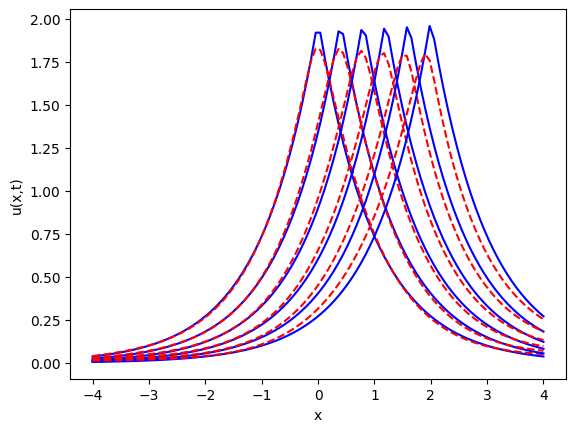

In [ ]:
x = np.linspace(-L,L,100).reshape(100,1)
for k in range(6):
    t = np.array([k*0.2]*100).reshape(100,1)
    X = np.hstack((x,t))
    plt.plot(x.flatten(), c*np.exp(-np.abs(c*t.flatten()-x.flatten())), color="blue", label="true value")
    plt.plot(x.flatten(),model.predict(X).flatten(), "r--", label="prediction")
    plt.xlabel("x")
    plt.ylabel("u(x,t)")
plt.show()

### Question

Try using another loss function. By default, DeepXDE uses mean-squared error (MSE), you can try mean-absolute error (MAE). How does it affect the PINNs convergence/accuracy? What is the essential difference between MSE and MAE?

To change the loss function, modify this line of code above:
```python
model.compile("adam", lr=1e-4, loss='MAE')
```